## CNN For Multi-class image classification

### Check for GPU

In [1]:
!nvidia-smi

Wed Dec 13 07:27:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load the dataset

In [1]:
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

--2023-12-13 07:41:35--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz.1’

flower_photos.tgz.1 100%[===================>] 218.21M  30.2MB/s    in 7.2s    

2023-12-13 07:41:42 (30.3 MB/s) - ‘flower_photos.tgz.1’ saved [228813984/228813984]



In [2]:
import tensorflow as tf
import pathlib

df_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin = df_url, extract=True)

data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [4]:
# Get image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
# Check the structure of the directory
import os

for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 5 directories and 1 images in '/root/.keras/datasets/flower_photos'
There are 0 directories and 799 images in '/root/.keras/datasets/flower_photos/tulips'
There are 0 directories and 641 images in '/root/.keras/datasets/flower_photos/roses'
There are 0 directories and 898 images in '/root/.keras/datasets/flower_photos/dandelion'
There are 0 directories and 633 images in '/root/.keras/datasets/flower_photos/daisy'
There are 0 directories and 699 images in '/root/.keras/datasets/flower_photos/sunflowers'


In [6]:
# Get class names
import numpy as np
class_names = np.array([item.name for item in data_dir.glob('*')][:-1])
class_names

array(['tulips', 'roses', 'dandelion', 'daisy', 'LICENSE.txt'],
      dtype='<U11')

In [7]:
## Remove corrupt files
num_skipped = 0
for folder_name in class_names:
    folder_path = os.path.join("/root/.keras/datasets/flower_photos/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

NotADirectoryError: ignored

In [8]:
## Creating train and validation sets
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
    directory = data_dir,
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'training',
    batch_size = 16,
    image_size = (224, 224),
    shuffle = True,
    seed = 42,
)

val_data = image_dataset_from_directory(
    directory = data_dir,
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'validation',
    batch_size = 16,
    image_size = (224, 224),
    shuffle = False,
    seed = 42,
)

Found 3664 files belonging to 5 classes.
Using 2932 files for training.
Found 3664 files belonging to 5 classes.
Using 732 files for validation.


In [9]:
class_names = train_data.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Visualising the dataset

TypeError: ignored

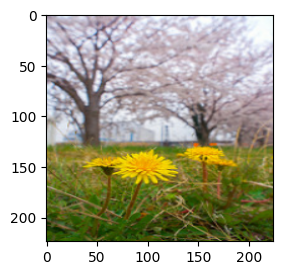

In [13]:
# Get first 9 images of the dataset
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for image, label in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('off')

### Making the rescaled and augmented dataset

In [10]:
from tensorflow.keras import Sequential, layers

rescaling_layer = Sequential([
    layers.Rescaling(1/255.)
], name = 'rescaling_layer')

data_augmentation = Sequential([
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.3),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
], name = 'augmentation_layer')

In [11]:
# Mapping these layers to the data
train_df = train_data.map(
    lambda x, y: (rescaling_layer(x), y),
    num_parallel_calls = tf.data.AUTOTUNE
).shuffle(buffer_size=3000).prefetch(tf.data.AUTOTUNE)

train_aug_df = train_data.map(
    lambda x,y: (data_augmentation(x), y),
    num_parallel_calls = tf.data.AUTOTUNE
).shuffle(buffer_size=3000).prefetch(tf.data.AUTOTUNE)

val_df = val_data.map(
    lambda x, y: (rescaling_layer(x), y),
    num_parallel_calls = tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [12]:
# Checking out an sample of the data
train_sample = train_df.take(1)
train_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [13]:
it = iter(train_df)
images = next(it)[0]
labels = next(it)[1]

In [14]:
labels

<tf.Tensor: shape=(16, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [15]:
# Checking shape of image
images.shape

TensorShape([16, 224, 224, 3])

### Using pretrained models

In [24]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Inception V1
inception_url = "https://www.kaggle.com/models/google/inception-v1/frameworks/TensorFlow2/variations/classification/versions/2"

# MobileNet
mobile_url = "https://www.kaggle.com/models/google/mobilenet-v1/frameworks/TensorFlow2/variations/025-128-classification/versions/2"


In [16]:
import tensorflow_hub as hub

# Making a function to create model
def create_model(model_url, num_classes=5, input_shape = (224, 224, 3)):
  # Download the pretrained model
  feature_extractor_layer = hub.KerasLayer(
      model_url,
      trainable = False,
      name = 'feature_extractor_layer',
      input_shape = input_shape)

  # Create the model
  model = Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model

In [17]:
# Create a model-checkpoint callback
def create_model_checkpoint(save_dir):
  return tf.keras.callbacks.ModelCheckpoint(filepath=save_dir,
                                            monitor = 'val_loss',
                                            save_best_only = True,
                                            save_weights_only = True,
                                            verbose = 0,
                                            mode = 'min')

In [18]:
# Plot loss curves of the model
import matplotlib.pyplot as plt

def plot_loss_curves(history, metrics_to_plot=["loss", "accuracy"]):
    plt.figure(figsize=(10, 10))
    for index, metric in enumerate(metrics_to_plot):
        ax = plt.subplot(2, 1, index + 1)
        plt.plot(history.history[metric], label=f"training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val {metric}")
        plt.title(f"{metric} vs Epochs curve")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()

In [19]:
# Making a function to compare histories at any time
def compare_history_overall(
    history_lst=[], initial_epoch_lst=[5], metrics_to_plot=["loss", "accuracy"]
):
    plt.figure(figsize=(12, 12))
    for index, metric in enumerate(metrics_to_plot):
        total_mtr = history_lst[0].history[metric]
        total_val_mtr = history_lst[0].history[f"val_{metric}"]

        for history in history_lst[1:]:
            total_mtr = total_mtr + history.history[metric]
            total_val_mtr = total_val_mtr + history.history[f"val_{metric}"]

        plt.subplot(2, 1, index + 1)
        plt.plot(total_mtr, label=f"Training {metric}")
        plt.plot(total_val_mtr, label=f"Validation {metric}")

        for epoch in initial_epoch_lst:
            plt.plot([epoch - 1, epoch - 1], plt.ylim())

        plt.title(f"Training and validation {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.legend()

In [20]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
def get_range_epoch_results(
    model,
    epoch_lst=[5, 20],
    callbacks=None,
    loss_fn="binary_crossentropy",
    train_data=train_df,
    test_data=val_df,
    use_best_only = True,
    learning_rate = 0.001
):
    history_lst = []
    eval_res = []

    epoch_lst = [0] + epoch_lst
    for index, epoch in enumerate(epoch_lst[1:]):
        checkpoint_path = f"model_exp/{model.name}_{index}.ckpt"

        if index == 0:
            model.compile(loss=loss_fn, optimizer=Adam(learning_rate = learning_rate), metrics=["accuracy"])

        # Make the callback list
        if callbacks:
            callbacks += [
                create_model_checkpoint(save_dir=checkpoint_path)
            ]
        else:
            callbacks = [
                create_model_checkpoint(save_dir=checkpoint_path)
            ]

        # Set the initial_epoch and train the data from it
        initial_epoch = epoch_lst[index]
        print(
            f"Fitting and training the model: \n  Initial epochs: {initial_epoch}\n  Total epochs: {epoch}\n"
        )
        model_history = model.fit(
            train_df,
            steps_per_epoch=len(train_df),
            epochs=epoch,
            initial_epoch=initial_epoch,
            validation_data=val_df,
            validation_steps=len(val_df),
            verbose=0,
            callbacks=callbacks,
        )

        print(f"Trained the model till {epoch} epochs!!!\n")

        # Load in the best model
        if use_best_only:
          print(f'Model saved at checkpoint path: `{checkpoint_path}`')
          print(f"Loading the best weights model {index + 1}")
          model.load_weights(checkpoint_path)

        # Evaluating the model
        print("Getting the evaluation results")
        eval_res.append(model.evaluate(test_data))

        history_lst.append(model_history)

        print()
        print("-" * 50)
        print()

    return history_lst, eval_res


#### Resnet model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
resnet_model = create_model(resnet_url,
                            num_classes = len(class_names))

# Compile the model
resnet_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ['accuracy'])

# Fit the model
resnet_history = resnet_model.fit(train_df,
                                  epochs = 5,
                                  steps_per_epoch = len(train_df),
                                  validation_data = val_df,
                                  validation_steps = len(val_df),
                                  callbacks = [create_model_checkpoint(
                                      save_dir = 'model_exp/resnet_model'
                                  )])

Epoch 1/5
184/184 [==============================] - 39s 150ms/step - loss: 0.5884 - accuracy: 0.7896 - val_loss: 0.4346 - val_accuracy: 0.8525
Epoch 2/5
184/184 [==============================] - 18s 95ms/step - loss: 0.2769 - accuracy: 0.9096 - val_loss: 0.4175 - val_accuracy: 0.8634
Epoch 3/5
184/184 [==============================] - 19s 100ms/step - loss: 0.1975 - accuracy: 0.9451 - val_loss: 0.3851 - val_accuracy: 0.8743
Epoch 4/5
184/184 [==============================] - 18s 93ms/step - loss: 0.1495 - accuracy: 0.9601 - val_loss: 0.3783 - val_accuracy: 0.8770
Epoch 5/5
184/184 [==============================] - 21s 112ms/step - loss: 0.1180 - accuracy: 0.9731 - val_loss: 0.3772 - val_accuracy: 0.8798


In [ ]:
# Get the summary of the model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 2048)              23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 5)                 10245     
                                                                 
Total params: 23575045 (89.93 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Evaluate on the test data
resnet_model.evaluate(val_df)

46/46 [==============================] - 3s 58ms/step - loss: 0.3772 - accuracy: 0.8798


[0.3772314488887787, 0.8797814249992371]

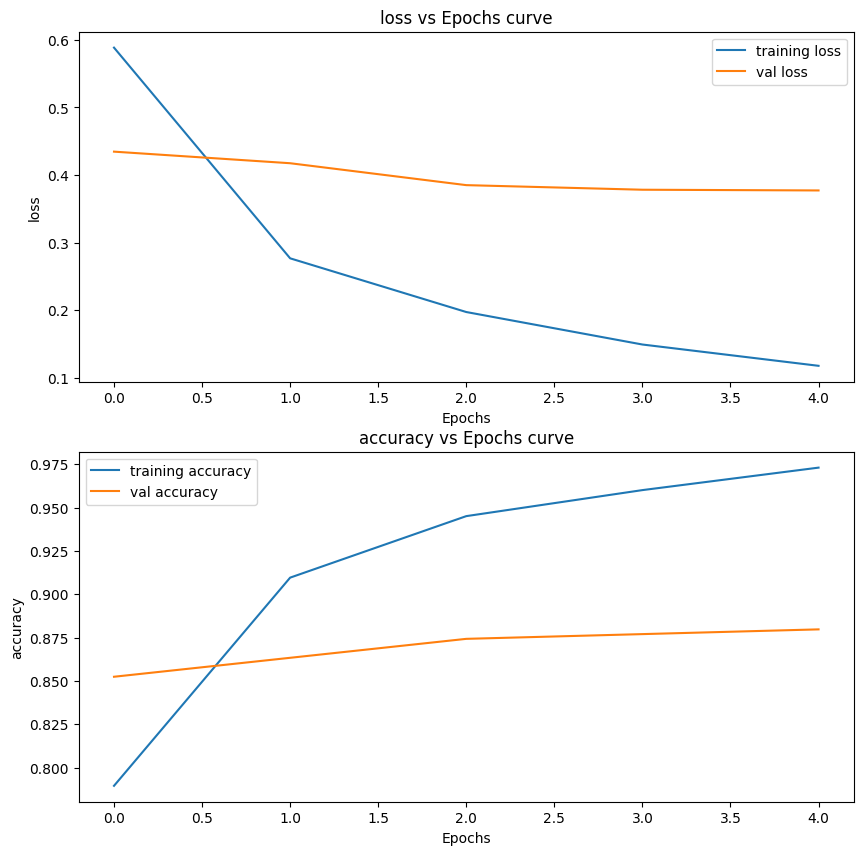

In [ ]:
# Plot loss curves
plot_loss_curves(resnet_history)

In [ ]:
# Evaluate best weights model
resnet_best_model = tf.keras.models.load_model('model_exp/resnet_model')
resnet_best_model.evaluate(val_df)

46/46 [==============================] - 3s 48ms/step - loss: 0.3772 - accuracy: 0.8798


[0.3772314488887787, 0.8797814249992371]

In [ ]:
# Getting predictions using the model
resnet_pred_probs = resnet_model.predict(val_df)
resnet_pred_probs

46/46 [==============================] - 4s 73ms/step


array([[5.7453904e-05, 1.0145585e-06, 9.9910176e-01, 9.2101736e-06,
        8.3061785e-04],
       [4.5097889e-03, 4.7420086e-03, 1.8578911e-02, 1.0232731e-02,
        9.6193653e-01],
       [1.4945674e-04, 7.2208318e-06, 9.9771059e-01, 1.7592055e-03,
        3.7355494e-04],
       ...,
       [2.1155616e-03, 2.1582957e-04, 1.1524724e-02, 5.0553906e-04,
        9.8563832e-01],
       [3.7890711e-04, 2.6752989e-04, 5.3689219e-02, 7.8073121e-05,
        9.4558626e-01],
       [9.7373158e-01, 9.0947008e-04, 6.9700899e-03, 4.4472055e-03,
        1.3941617e-02]], dtype=float32)

In [ ]:
len(resnet_pred_probs)

732

In [ ]:
# Convert the prediction probabilities into labels
model_preds = resnet_pred_probs.argmax(axis=1)
model_preds

array([2, 4, 2, 2, 1, 1, 0, 4, 2, 1, 4, 1, 3, 4, 0, 0, 1, 1, 1, 4, 4, 2,
       1, 2, 4, 2, 3, 3, 3, 1, 3, 4, 2, 2, 0, 2, 1, 4, 4, 4, 3, 3, 0, 1,
       4, 1, 0, 1, 1, 2, 2, 3, 4, 4, 4, 4, 3, 2, 4, 3, 2, 2, 4, 1, 1, 4,
       2, 0, 0, 0, 1, 3, 1, 1, 2, 2, 4, 0, 2, 2, 2, 4, 2, 0, 3, 4, 1, 2,
       3, 0, 4, 4, 0, 0, 4, 1, 4, 1, 4, 1, 0, 3, 3, 2, 1, 4, 2, 3, 4, 4,
       1, 3, 4, 2, 0, 1, 4, 4, 1, 4, 4, 1, 3, 4, 3, 4, 3, 1, 4, 4, 0, 0,
       4, 0, 1, 0, 3, 3, 4, 3, 3, 3, 1, 3, 1, 4, 0, 3, 4, 3, 3, 3, 1, 3,
       1, 0, 4, 4, 1, 4, 1, 1, 0, 1, 1, 3, 0, 3, 1, 2, 1, 1, 1, 1, 1, 2,
       3, 2, 2, 3, 1, 1, 1, 1, 3, 4, 3, 0, 4, 0, 0, 2, 2, 4, 2, 2, 0, 4,
       2, 2, 3, 0, 4, 3, 4, 1, 0, 2, 1, 1, 4, 1, 2, 1, 3, 2, 4, 0, 0, 2,
       1, 4, 0, 2, 1, 0, 2, 1, 0, 0, 1, 4, 1, 4, 3, 3, 2, 1, 2, 1, 3, 1,
       1, 3, 1, 2, 2, 4, 2, 4, 3, 3, 1, 4, 0, 4, 1, 0, 0, 3, 1, 4, 0, 3,
       0, 4, 2, 0, 4, 0, 4, 1, 4, 1, 4, 1, 1, 0, 1, 2, 4, 4, 0, 4, 4, 4,
       0, 1, 4, 2, 3, 1, 4, 4, 2, 2, 3, 0, 3, 1, 4,

##### Train for more epochs

In [ ]:
epoch_list = [5, 10, 15, 20, 25, 30, 35]

resnet_model = tf.keras.models.clone_model(resnet_model)

history_lst, eval_lst = get_range_epoch_results(
    resnet_model,
    epoch_lst=epoch_list,
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 3s 48ms/step - loss: 0.3497 - accuracy: 0.8839

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 4s 48ms/step - loss: 0.3779 - accuracy: 0.8852

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Loading the best weights model 3
Getting the evaluation results
46/46 [==============================] - 3s 49ms/step - loss: 0.4184 - accuracy: 0.8757

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 15
  

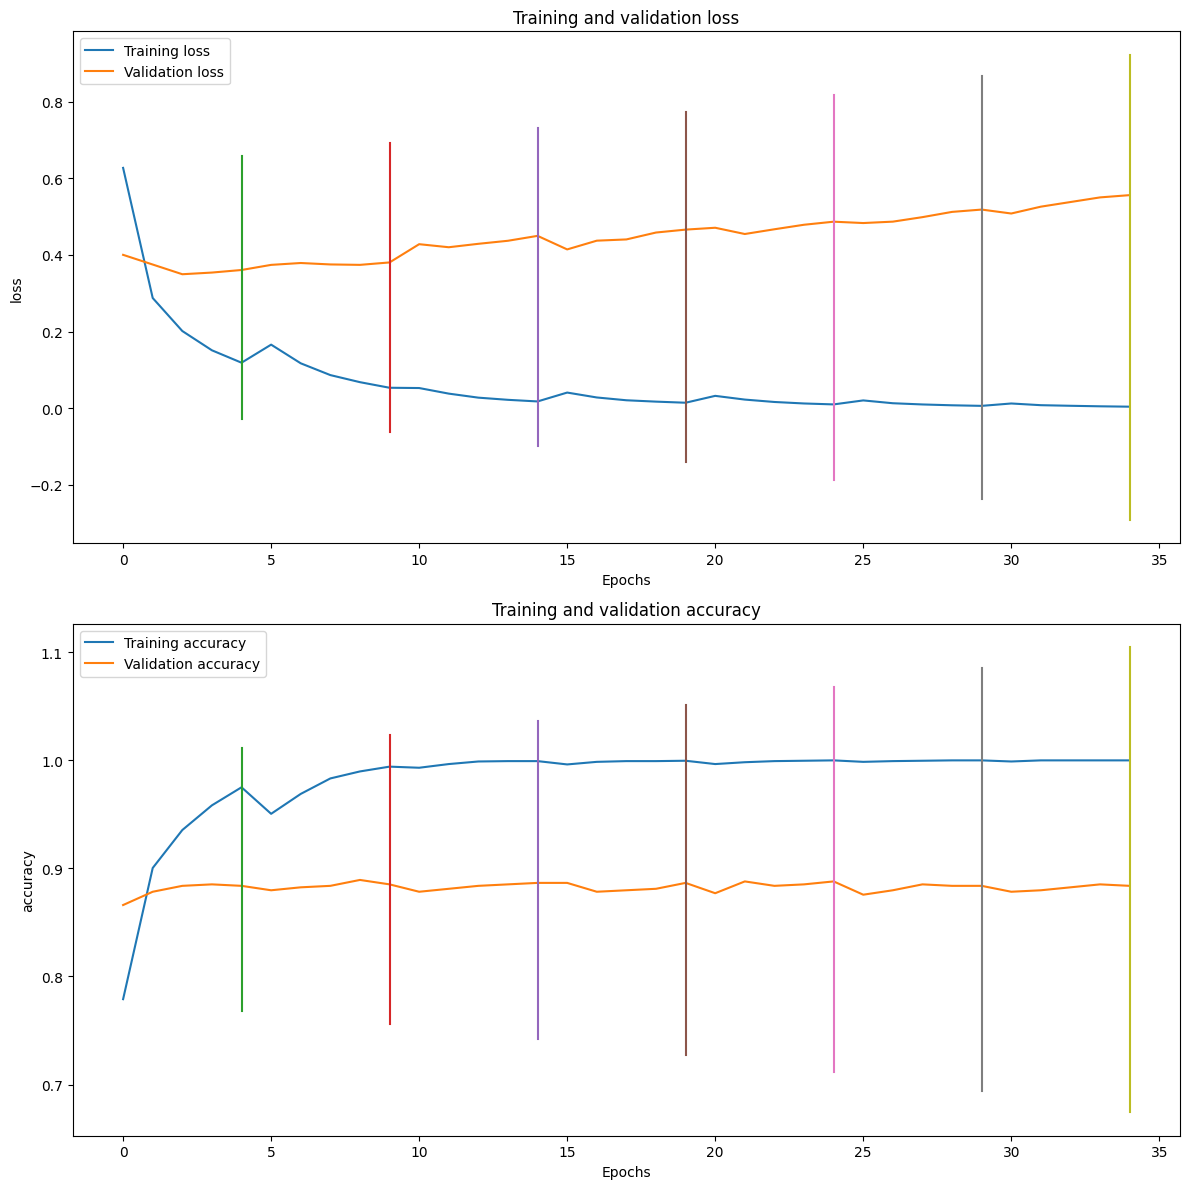

In [ ]:
compare_history_overall(history_lst,
                        initial_epoch_lst = epoch_list)

In [ ]:
import keras
keras.backend.clear_session()

#### EfficientNet model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
efficient_model = create_model(efficientnet_url,
                               num_classes = len(class_names))

# Compile the model
efficient_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ['accuracy'])

# Fit the model
efficient_history = efficient_model.fit(train_df,
                                  epochs = 5,
                                  steps_per_epoch = len(train_df),
                                  validation_data = val_df,
                                  validation_steps = len(val_df),
                                  callbacks = [create_model_checkpoint(
                                      save_dir = 'model_exp/efficientnet_model'
                                  )])

Epoch 1/5
184/184 [==============================] - 40s 134ms/step - loss: 0.5652 - accuracy: 0.8308 - val_loss: 0.3409 - val_accuracy: 0.8839
Epoch 2/5
184/184 [==============================] - 25s 133ms/step - loss: 0.2548 - accuracy: 0.9284 - val_loss: 0.2768 - val_accuracy: 0.8989
Epoch 3/5
184/184 [==============================] - 24s 128ms/step - loss: 0.1888 - accuracy: 0.9478 - val_loss: 0.2519 - val_accuracy: 0.9085
Epoch 4/5
184/184 [==============================] - 26s 143ms/step - loss: 0.1506 - accuracy: 0.9652 - val_loss: 0.2371 - val_accuracy: 0.9153
Epoch 5/5
184/184 [==============================] - 23s 127ms/step - loss: 0.1259 - accuracy: 0.9734 - val_loss: 0.2291 - val_accuracy: 0.9180


In [ ]:
# Get the summary of the model
efficient_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4055969 (15.47 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
# Evaluate on the test data
efficient_model.evaluate(val_df)

46/46 [==============================] - 2s 36ms/step - loss: 0.2291 - accuracy: 0.9180


[0.2290976196527481, 0.9180327653884888]

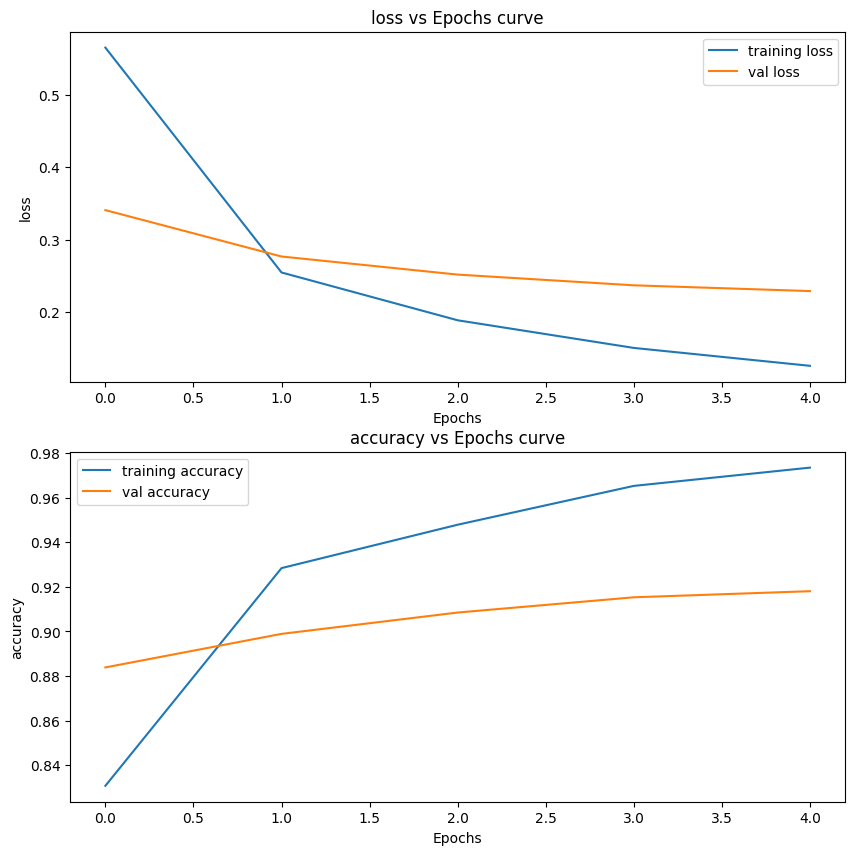

In [ ]:
# Plot loss curves
plot_loss_curves(efficient_history)

In [ ]:
# Evaluate best weights model
efficient_best_model = tf.keras.models.load_model('model_exp/efficientnet_model')
efficient_best_model.evaluate(val_df)

46/46 [==============================] - 13s 45ms/step - loss: 0.2291 - accuracy: 0.9180


[0.2290976494550705, 0.9180327653884888]

In [ ]:
# Getting predictions using the model
efficient_pred_probs = efficient_model.predict(val_df)
efficient_pred_probs

46/46 [==============================] - 3s 34ms/step


array([[9.8849094e-01, 3.9658197e-03, 1.0014551e-03, 5.4212348e-03,
        1.1204728e-03],
       [2.0242484e-05, 9.9992073e-01, 4.2735778e-06, 3.8903003e-05,
        1.5872924e-05],
       [9.3796733e-04, 2.2851545e-03, 3.7549183e-01, 5.3795777e-02,
        5.6748927e-01],
       ...,
       [9.2916703e-01, 1.1003294e-02, 2.7640181e-02, 8.3694560e-03,
        2.3820078e-02],
       [1.5492785e-02, 9.7700590e-01, 6.8285438e-04, 5.0467271e-03,
        1.7717663e-03],
       [3.0700956e-04, 1.4306089e-05, 1.6512482e-03, 1.8665600e-05,
        9.9800879e-01]], dtype=float32)

In [ ]:
len(efficient_pred_probs)

732

In [ ]:
# Convert the prediction probabilities into labels
model_preds = efficient_pred_probs.argmax(axis=1)
model_preds

array([0, 1, 4, 4, 4, 2, 3, 4, 3, 4, 1, 1, 0, 1, 1, 2, 1, 4, 0, 4, 4, 1,
       0, 0, 2, 3, 1, 0, 3, 4, 3, 3, 3, 4, 0, 1, 4, 1, 1, 3, 1, 1, 1, 4,
       1, 0, 4, 4, 1, 2, 3, 3, 1, 1, 1, 1, 4, 0, 4, 3, 4, 3, 4, 0, 0, 1,
       1, 1, 4, 3, 4, 3, 0, 4, 3, 3, 1, 4, 3, 3, 4, 3, 2, 2, 0, 1, 0, 2,
       0, 2, 1, 3, 4, 1, 3, 2, 1, 1, 1, 4, 2, 1, 1, 0, 0, 4, 3, 1, 0, 4,
       4, 4, 2, 2, 4, 0, 2, 1, 2, 0, 4, 1, 0, 0, 4, 0, 1, 1, 2, 0, 0, 1,
       4, 3, 2, 4, 2, 3, 3, 0, 2, 4, 0, 1, 3, 4, 4, 3, 3, 3, 2, 3, 4, 0,
       1, 0, 3, 1, 1, 4, 4, 3, 1, 3, 4, 0, 1, 4, 1, 0, 4, 1, 3, 4, 4, 3,
       4, 4, 4, 1, 3, 2, 1, 1, 4, 4, 1, 4, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 4, 1, 3, 1, 0, 3, 4, 2, 1, 3, 2, 2, 3, 0, 3, 1, 0, 0, 4, 1, 4,
       3, 3, 4, 1, 3, 1, 4, 1, 4, 4, 0, 3, 3, 0, 1, 4, 4, 4, 2, 1, 4, 1,
       3, 2, 2, 1, 4, 2, 2, 1, 3, 3, 2, 2, 4, 1, 4, 1, 0, 4, 3, 4, 0, 4,
       2, 3, 0, 3, 4, 1, 0, 4, 0, 0, 2, 0, 2, 4, 1, 1, 0, 2, 2, 1, 3, 1,
       4, 1, 2, 4, 1, 3, 0, 4, 2, 4, 0, 0, 0, 1, 4,

##### Train for more epochs

In [ ]:
# # Create the model
# efficient_model = create_model(efficientnet_url,
#                                num_classes = len(class_names))

In [ ]:
epoch_list = [5, 10, 15, 20, 25]

efficient_model = tf.keras.models.clone_model(efficient_model)
efficient_model._name = 'efficient_model_rng'

history_lst_eff, eval_lst_eff = get_range_epoch_results(
    efficient_model,
    epoch_lst=epoch_list,
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 3s 35ms/step - loss: 0.2264 - accuracy: 0.9153

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 5s 75ms/step - loss: 0.3779 - accuracy: 0.8852

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Loading the best weights model 3
Getting the evaluation results
46/46 [==============================] - 3s 49ms/step - loss: 0.4184 - accuracy: 0.8757

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 15
  

In [ ]:
compare_history_overall(history_lst_eff,
                        initial_epoch_lst = epoch_list)

In [ ]:
import keras
keras.backend.clear_session()

#### Inception model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
inception_model = create_model(inception_url,
                            num_classes = len(class_names))
inception_model._name = 'inception_model'

# Compile the model
inception_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ['accuracy'])

# Fit the model
inception_history = inception_model.fit(train_df,
                                  epochs = 5,
                                  steps_per_epoch = len(train_df),
                                  validation_data = val_df,
                                  validation_steps = len(val_df),
                                  callbacks = [create_model_checkpoint(
                                      save_dir = 'model_exp/inception_model'
                                  )])

Epoch 1/5
184/184 [==============================] - 17s 46ms/step - loss: 0.6004 - accuracy: 0.7879 - val_loss: 0.3422 - val_accuracy: 0.8852
Epoch 2/5
184/184 [==============================] - 14s 38ms/step - loss: 0.3381 - accuracy: 0.8888 - val_loss: 0.4644 - val_accuracy: 0.8388
Epoch 3/5
184/184 [==============================] - 13s 40ms/step - loss: 0.2734 - accuracy: 0.9076 - val_loss: 0.2067 - val_accuracy: 0.9221
Epoch 4/5
184/184 [==============================] - 11s 38ms/step - loss: 0.2384 - accuracy: 0.9168 - val_loss: 0.3889 - val_accuracy: 0.8661
Epoch 5/5
184/184 [==============================] - 12s 38ms/step - loss: 0.2231 - accuracy: 0.9233 - val_loss: 0.2876 - val_accuracy: 0.9057


In [ ]:
# Get the summary of the model
inception_model.summary()

Model: "inception_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1001)              6633209   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 5)                 5010      
                                                                 
Total params: 6638219 (25.32 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 6633209 (25.30 MB)
_________________________________________________________________


In [ ]:
# Evaluate on the test data
inception_model.evaluate(val_df)

46/46 [==============================] - 2s 32ms/step - loss: 0.2876 - accuracy: 0.9057


[0.28755688667297363, 0.9057376980781555]

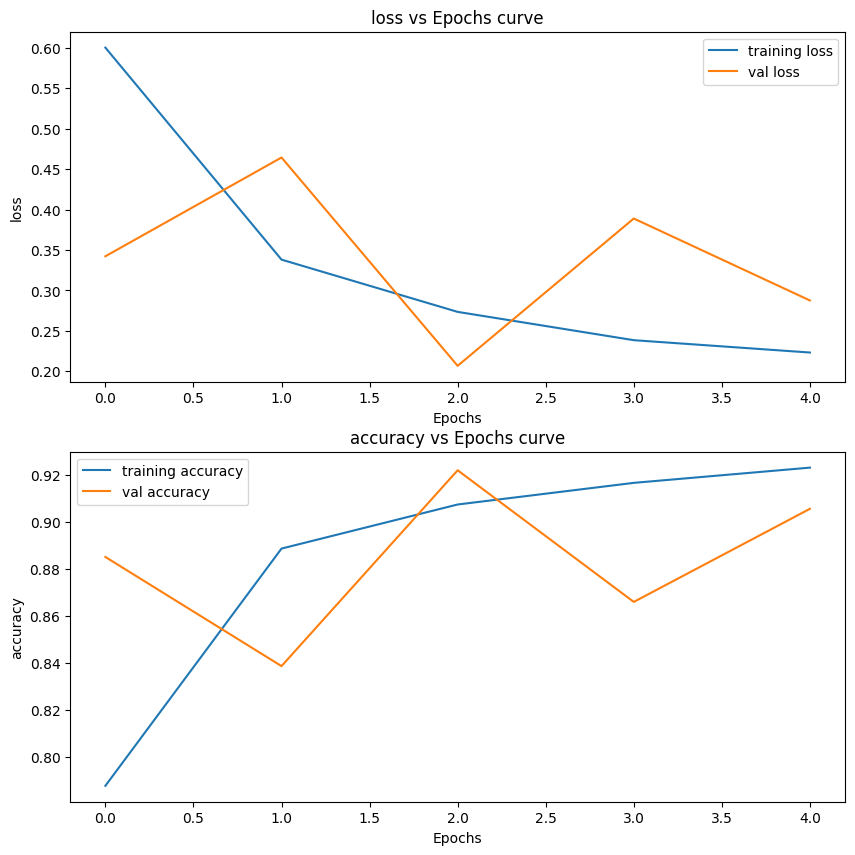

In [ ]:
# Plot loss curves
plot_loss_curves(inception_history)

In [ ]:
# Evaluate best weights model
inception_model.load_weights('model_exp/inception_model')
inception_model.evaluate(val_df)

46/46 [==============================] - 2s 32ms/step - loss: 0.2067 - accuracy: 0.9221


[0.20670172572135925, 0.9221311211585999]

In [ ]:
# Getting predictions using the model
inception_pred_probs = inception_model.predict(val_df)
inception_pred_probs

46/46 [==============================] - 2s 30ms/step


array([[9.9806756e-01, 1.5469933e-04, 3.1511216e-05, 1.3301095e-03,
        4.1623239e-04],
       [9.4998402e-05, 2.9585255e-05, 4.1086146e-01, 8.4751524e-02,
        5.0426239e-01],
       [2.7214940e-06, 5.3837448e-06, 9.9977642e-01, 6.1658204e-05,
        1.5383278e-04],
       ...,
       [1.8829678e-03, 9.9729568e-01, 5.7737506e-04, 1.0087501e-06,
        2.4303381e-04],
       [9.6093707e-02, 1.6997724e-03, 4.4193524e-03, 8.9537948e-01,
        2.4076367e-03],
       [9.8998243e-01, 9.9592302e-03, 4.7017429e-06, 1.7450513e-05,
        3.6214515e-05]], dtype=float32)

In [ ]:
len(inception_pred_probs)

732

In [ ]:
# Convert the prediction probabilities into labels
model_preds = inception_pred_probs.argmax(axis=1)
model_preds

array([0, 4, 2, 0, 3, 0, 3, 1, 4, 3, 4, 2, 4, 1, 1, 1, 2, 1, 0, 3, 4, 1,
       4, 3, 0, 4, 1, 1, 4, 0, 0, 3, 2, 4, 2, 2, 0, 1, 2, 0, 0, 2, 0, 4,
       2, 1, 2, 4, 2, 1, 3, 2, 3, 1, 2, 4, 0, 1, 4, 1, 0, 1, 4, 4, 0, 4,
       2, 4, 2, 0, 0, 2, 3, 1, 1, 0, 1, 4, 4, 2, 0, 0, 1, 2, 0, 4, 2, 1,
       3, 4, 1, 1, 4, 1, 4, 1, 4, 4, 4, 3, 0, 4, 4, 2, 4, 2, 4, 0, 3, 4,
       0, 2, 0, 4, 2, 4, 1, 1, 2, 1, 1, 2, 0, 1, 4, 3, 0, 3, 1, 3, 3, 4,
       3, 2, 3, 1, 1, 3, 3, 4, 4, 3, 2, 2, 3, 4, 4, 1, 1, 0, 4, 4, 1, 2,
       1, 0, 4, 2, 0, 4, 4, 1, 4, 4, 3, 0, 3, 1, 4, 3, 3, 2, 1, 4, 4, 4,
       3, 0, 0, 4, 3, 4, 4, 1, 4, 1, 0, 0, 2, 4, 1, 0, 1, 4, 1, 1, 1, 1,
       0, 3, 1, 3, 1, 2, 4, 0, 3, 4, 4, 0, 1, 1, 3, 0, 0, 0, 0, 3, 3, 0,
       1, 1, 1, 0, 0, 1, 1, 3, 1, 3, 1, 4, 0, 2, 4, 4, 4, 0, 3, 3, 4, 1,
       4, 1, 4, 0, 4, 0, 1, 0, 2, 4, 4, 2, 1, 1, 1, 4, 0, 0, 2, 2, 4, 4,
       1, 4, 0, 2, 4, 1, 2, 2, 2, 4, 1, 3, 4, 3, 4, 4, 1, 4, 2, 0, 4, 3,
       4, 0, 2, 0, 2, 1, 1, 2, 3, 1, 0, 3, 0, 3, 3,

##### Train for more epochs

In [ ]:
inception_model.name

'inception_model'

In [ ]:
epoch_list = [5, 10, 15, 20, 25, 30]

inception_model = tf.keras.models.clone_model(inception_model)

history_lst_inc, eval_lst_inc = get_range_epoch_results(
    inception_model,
    epoch_lst=epoch_list,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data=train_df, test_data=val_df
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 2s 31ms/step - loss: 0.2676 - accuracy: 0.9016

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 2s 32ms/step - loss: 0.2855 - accuracy: 0.9016

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Loading the best weights model 3
Getting the evaluation results
46/46 [==============================] - 2s 51ms/step - loss: 0.2875 - accuracy: 0.9016

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 15
  

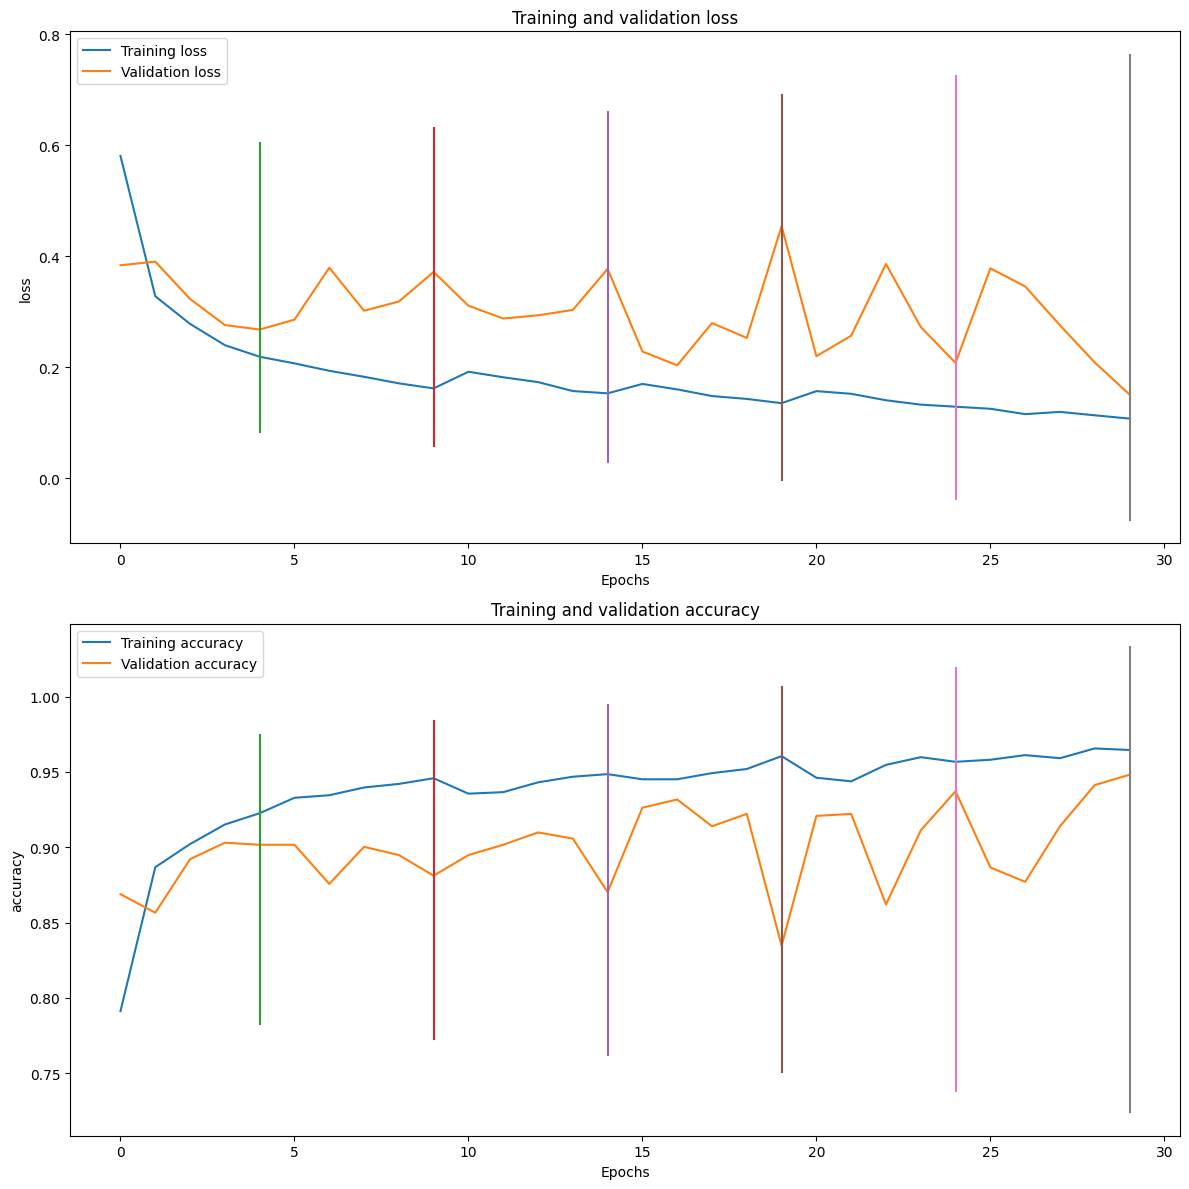

In [ ]:
compare_history_overall(history_lst_inc,
                        initial_epoch_lst = epoch_list)

#### MobileNet model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
mobile_model = create_model(mobile_url,
                            num_classes = len(class_names))
mobile_model._name = 'mobilenet_model'

# Compile the model
mobile_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = Adam(),
                     metrics = ['accuracy'])

# Fit the model
mobile_history = mobile_model.fit(train_df,
                                  epochs = 5,
                                  steps_per_epoch = len(train_df),
                                  validation_data = val_df,
                                  validation_steps = len(val_df),
                                  callbacks = [create_model_checkpoint(
                                      save_dir = 'model_exp/mobile_model'
                                  )])

Epoch 1/5
184/184 [==============================] - 18s 20ms/step - loss: 0.7172 - accuracy: 0.7578 - val_loss: 0.4005 - val_accuracy: 0.8579
Epoch 2/5
184/184 [==============================] - 8s 16ms/step - loss: 0.4344 - accuracy: 0.8452 - val_loss: 0.6396 - val_accuracy: 0.7691
Epoch 3/5
184/184 [==============================] - 9s 25ms/step - loss: 0.3896 - accuracy: 0.8615 - val_loss: 0.2284 - val_accuracy: 0.9167
Epoch 4/5
184/184 [==============================] - 9s 25ms/step - loss: 0.3713 - accuracy: 0.8728 - val_loss: 0.3640 - val_accuracy: 0.8675
Epoch 5/5
184/184 [==============================] - 15s 42ms/step - loss: 0.3421 - accuracy: 0.8830 - val_loss: 0.2908 - val_accuracy: 0.8907


In [ ]:
# Get the summary of the model
mobile_model.summary()

Model: "mobilenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1001)              475801    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 5)                 5010      
                                                                 
Total params: 480811 (1.83 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 475801 (1.82 MB)
_________________________________________________________________


In [ ]:
# Evaluate on the test data
mobile_model.evaluate(val_df)

46/46 [==============================] - 3s 54ms/step - loss: 0.2908 - accuracy: 0.8907


[0.2908208966255188, 0.8907103538513184]

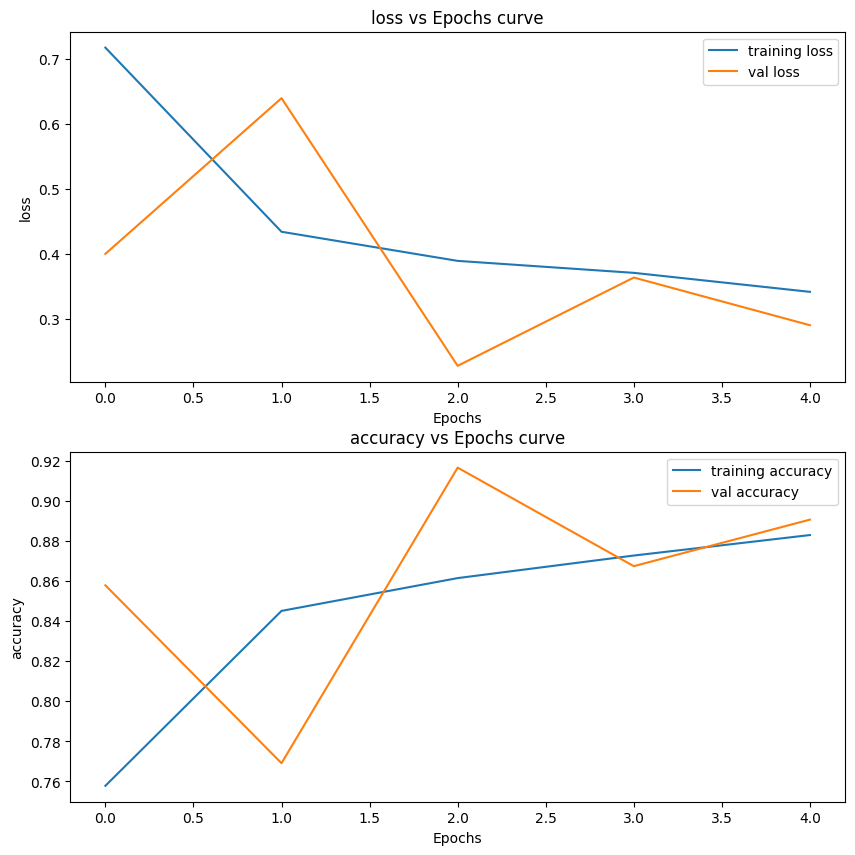

In [ ]:
# Plot loss curves
plot_loss_curves(mobile_history)

In [ ]:
# Evaluate best weights model
mobile_model.load_weights('model_exp/mobile_model')
mobile_model.evaluate(val_df)

46/46 [==============================] - 3s 61ms/step - loss: 0.2284 - accuracy: 0.9167


[0.22844582796096802, 0.9166666865348816]

In [ ]:
# Getting predictions using the model
mobile_pred_probs = mobile_model.predict(val_df)
mobile_pred_probs

46/46 [==============================] - 2s 30ms/step


array([[9.9806756e-01, 1.5469933e-04, 3.1511216e-05, 1.3301095e-03,
        4.1623239e-04],
       [9.4998402e-05, 2.9585255e-05, 4.1086146e-01, 8.4751524e-02,
        5.0426239e-01],
       [2.7214940e-06, 5.3837448e-06, 9.9977642e-01, 6.1658204e-05,
        1.5383278e-04],
       ...,
       [1.8829678e-03, 9.9729568e-01, 5.7737506e-04, 1.0087501e-06,
        2.4303381e-04],
       [9.6093707e-02, 1.6997724e-03, 4.4193524e-03, 8.9537948e-01,
        2.4076367e-03],
       [9.8998243e-01, 9.9592302e-03, 4.7017429e-06, 1.7450513e-05,
        3.6214515e-05]], dtype=float32)

In [ ]:
len(mobile_pred_probs)

732

In [ ]:
# Convert the prediction probabilities into labels
model_preds = mobile_pred_probs.argmax(axis=1)
model_preds

array([0, 4, 2, 0, 3, 0, 3, 1, 4, 3, 4, 2, 4, 1, 1, 1, 2, 1, 0, 3, 4, 1,
       4, 3, 0, 4, 1, 1, 4, 0, 0, 3, 2, 4, 2, 2, 0, 1, 2, 0, 0, 2, 0, 4,
       2, 1, 2, 4, 2, 1, 3, 2, 3, 1, 2, 4, 0, 1, 4, 1, 0, 1, 4, 4, 0, 4,
       2, 4, 2, 0, 0, 2, 3, 1, 1, 0, 1, 4, 4, 2, 0, 0, 1, 2, 0, 4, 2, 1,
       3, 4, 1, 1, 4, 1, 4, 1, 4, 4, 4, 3, 0, 4, 4, 2, 4, 2, 4, 0, 3, 4,
       0, 2, 0, 4, 2, 4, 1, 1, 2, 1, 1, 2, 0, 1, 4, 3, 0, 3, 1, 3, 3, 4,
       3, 2, 3, 1, 1, 3, 3, 4, 4, 3, 2, 2, 3, 4, 4, 1, 1, 0, 4, 4, 1, 2,
       1, 0, 4, 2, 0, 4, 4, 1, 4, 4, 3, 0, 3, 1, 4, 3, 3, 2, 1, 4, 4, 4,
       3, 0, 0, 4, 3, 4, 4, 1, 4, 1, 0, 0, 2, 4, 1, 0, 1, 4, 1, 1, 1, 1,
       0, 3, 1, 3, 1, 2, 4, 0, 3, 4, 4, 0, 1, 1, 3, 0, 0, 0, 0, 3, 3, 0,
       1, 1, 1, 0, 0, 1, 1, 3, 1, 3, 1, 4, 0, 2, 4, 4, 4, 0, 3, 3, 4, 1,
       4, 1, 4, 0, 4, 0, 1, 0, 2, 4, 4, 2, 1, 1, 1, 4, 0, 0, 2, 2, 4, 4,
       1, 4, 0, 2, 4, 1, 2, 2, 2, 4, 1, 3, 4, 3, 4, 4, 1, 4, 2, 0, 4, 3,
       4, 0, 2, 0, 2, 1, 1, 2, 3, 1, 0, 3, 0, 3, 3,

##### Train for more epochs

In [ ]:
mobile_model.name

'mobilenet_model'

In [ ]:
epoch_list = [5, 10, 15, 20, 25, 30]

mobile_model = tf.keras.models.clone_model(mobile_model)

history_lst_mob, eval_lst_mob = get_range_epoch_results(
    mobile_model,
    epoch_lst=epoch_list,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data=train_df, test_data=val_df
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 1s 30ms/step - loss: 0.3729 - accuracy: 0.8566

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 1s 29ms/step - loss: 0.2986 - accuracy: 0.8975

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Loading the best weights model 3
Getting the evaluation results
46/46 [==============================] - 1s 29ms/step - loss: 0.2857 - accuracy: 0.8989

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 15
  

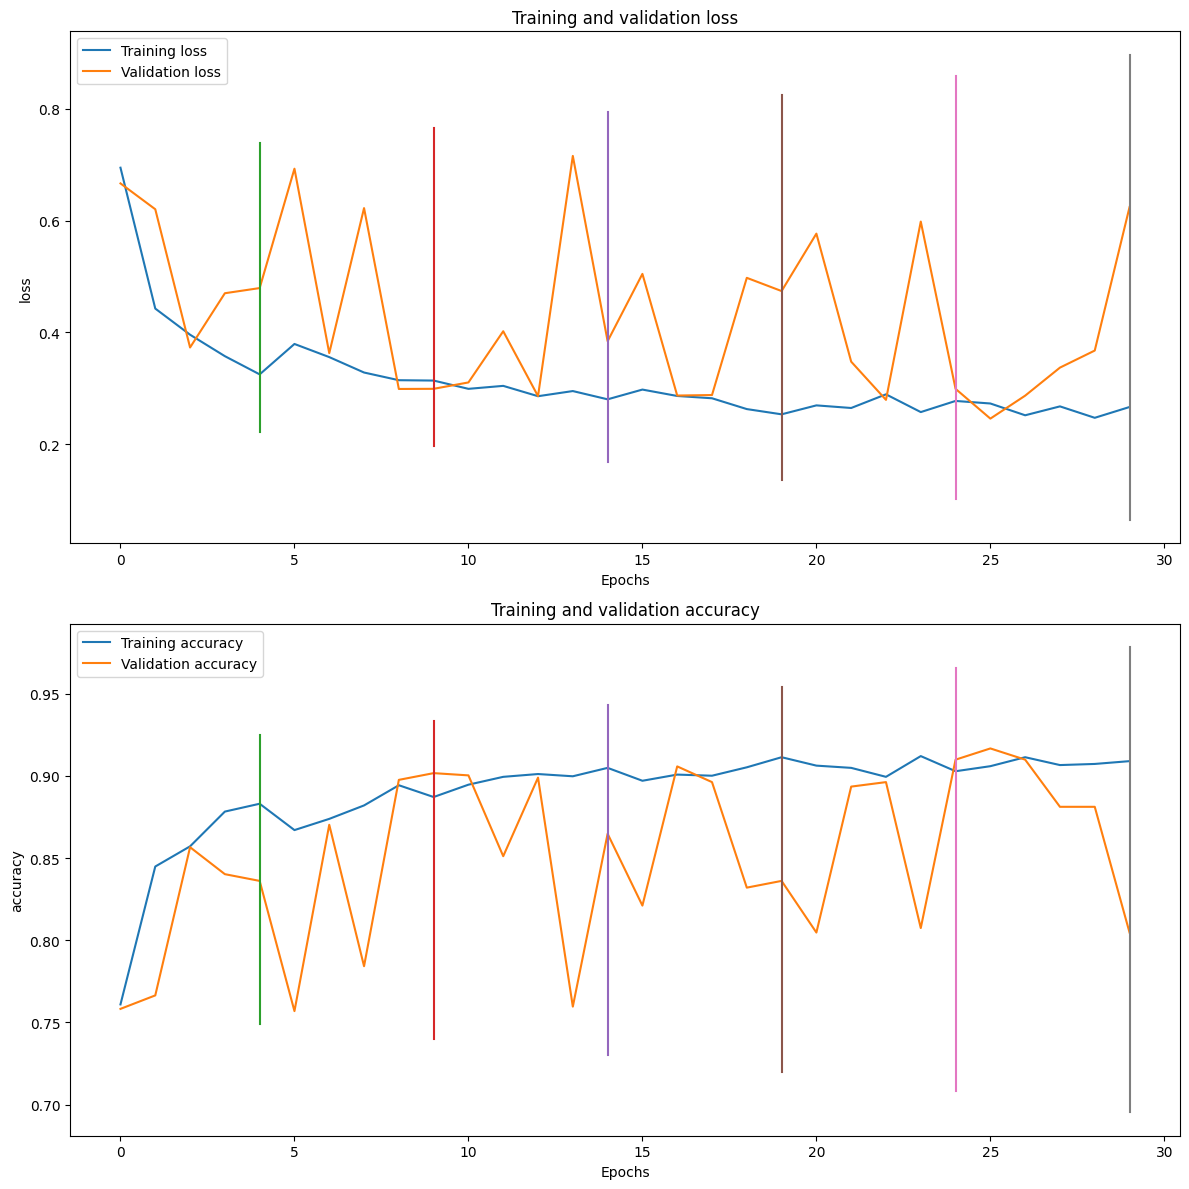

In [ ]:
compare_history_overall(history_lst_mob,
                        initial_epoch_lst = epoch_list)

### Applying augmented data to all three and then checking the results

#### Resnet model

In [ ]:
import tensorflow as tf

# set the random seed
tf.random.set_seed(42)

# Create the model
resnet_model_aug = create_model(resnet_url)
resnet_model_aug._name = 'resnet_model_aug'

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20]

history_lst_res_aug, eval_lst_res_aug = get_range_epoch_results(
    resnet_model_aug,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    use_best_only = True,
    train_data = train_aug_df
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 3s 54ms/step - loss: 0.1157 - accuracy: 0.9740

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 3s 56ms/step - loss: 0.1233 - accuracy: 0.9658

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Loading the best weights model 3
Getting the evaluation results
46/46 [==============================] - 2s 52ms/step - loss: 0.0975 - accuracy: 0.9740

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 15
  

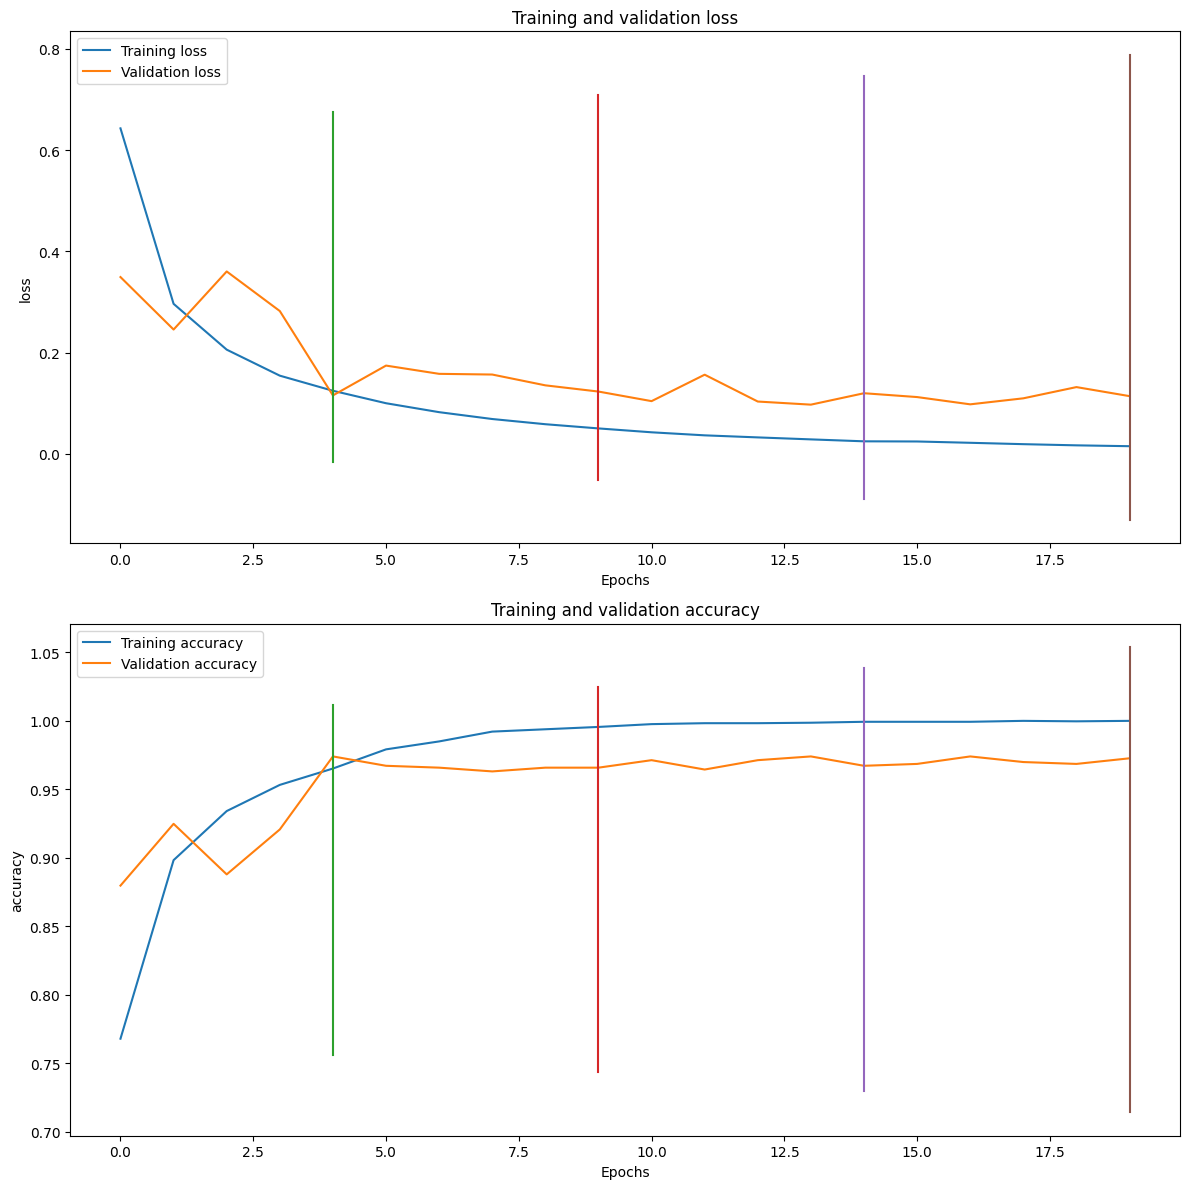

In [ ]:
compare_history_overall(history_lst_res_aug,
                        initial_epoch_lst = EPOCH_LST)

#### EfficientNet model

In [ ]:
import tensorflow as tf

# set the random seed
tf.random.set_seed(42)

# Create the model
eff_model_aug = create_model(efficientnet_url)
eff_model_aug._name = 'efficientnet_model_aug'

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 25, 30]

history_lst_eff_aug, eval_lst_eff_aug = get_range_epoch_results(
    eff_model_aug,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    use_best_only = True,
    train_data = train_aug_df
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/efficientnet_model_aug_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 2s 36ms/step - loss: 0.1750 - accuracy: 0.9522

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/efficientnet_model_aug_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 2s 36ms/step - loss: 0.1403 - accuracy: 0.9577

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/efficientnet_model_aug_2.ckpt`
Loading the best weights model 3
Gettin

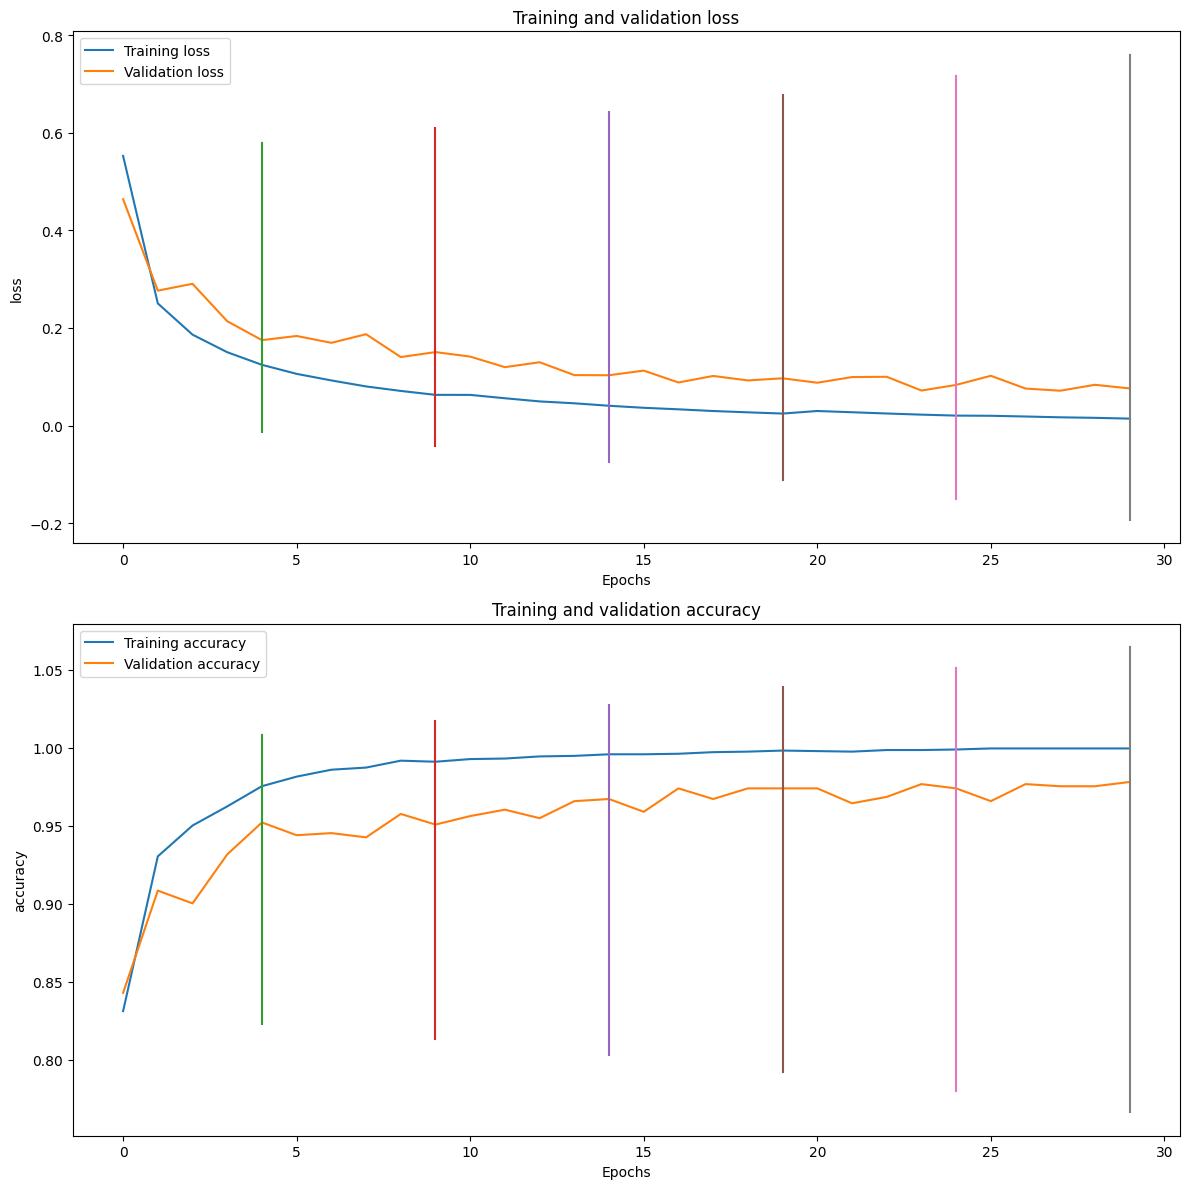

In [ ]:
compare_history_overall(history_lst_eff_aug,
                        initial_epoch_lst = EPOCH_LST)

#### Inception model

In [ ]:
import tensorflow as tf

# set the random seed
tf.random.set_seed(42)

# Create the model
inc_model_aug = create_model(inception_url)
inc_model_aug._name = 'inception_model_aug'

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

history_lst_inc_aug, eval_lst_inc_aug = get_range_epoch_results(
    inc_model_aug,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/inception_model_aug_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 2s 32ms/step - loss: 0.2627 - accuracy: 0.9249

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/inception_model_aug_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 2s 33ms/step - loss: 0.2511 - accuracy: 0.9098

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/inception_model_aug_2.ckpt`
Loading the best weights model 3
Getting the eva

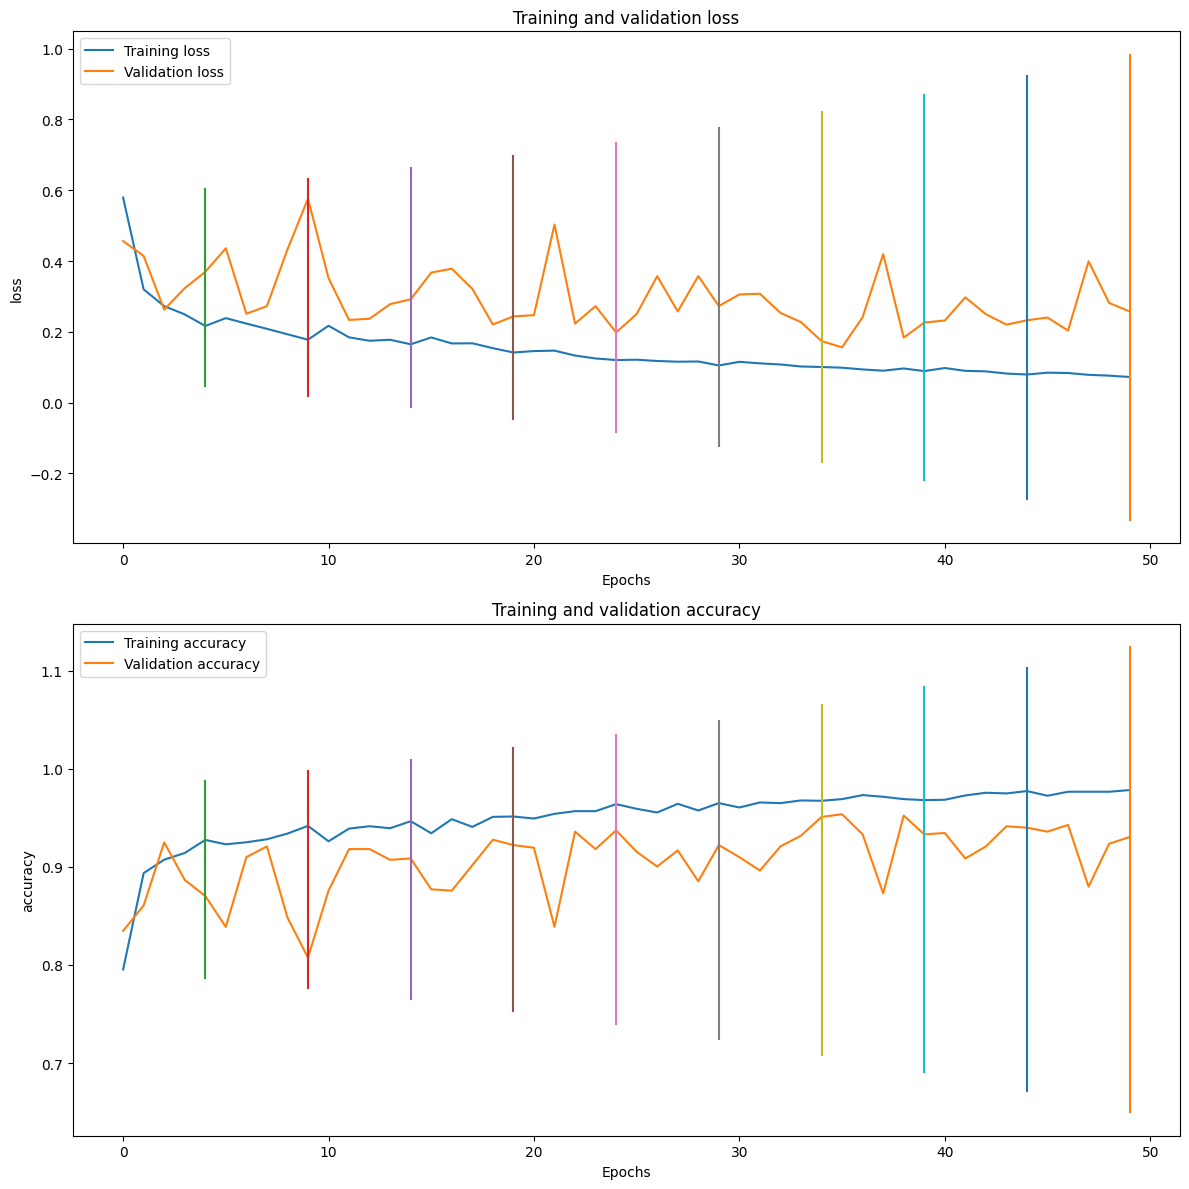

In [ ]:
compare_history_overall(history_lst_inc_aug,
                        initial_epoch_lst = EPOCH_LST)

#### MobileNet model

In [ ]:
import tensorflow as tf

# set the random seed
tf.random.set_seed(42)

# Create the model
mobile_model_aug = create_model(mobile_url)
mobile_model_aug._name = 'mobile_model_aug'

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 25, 30]

history_lst_mob_aug, eval_lst_mob_aug = get_range_epoch_results(
    mobile_model_aug,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/mobile_model_aug_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 2s 35ms/step - loss: 0.2487 - accuracy: 0.9016

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/mobile_model_aug_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 1s 31ms/step - loss: 0.1551 - accuracy: 0.9467

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/mobile_model_aug_2.ckpt`
Loading the best weights model 3
Getting the evaluation r

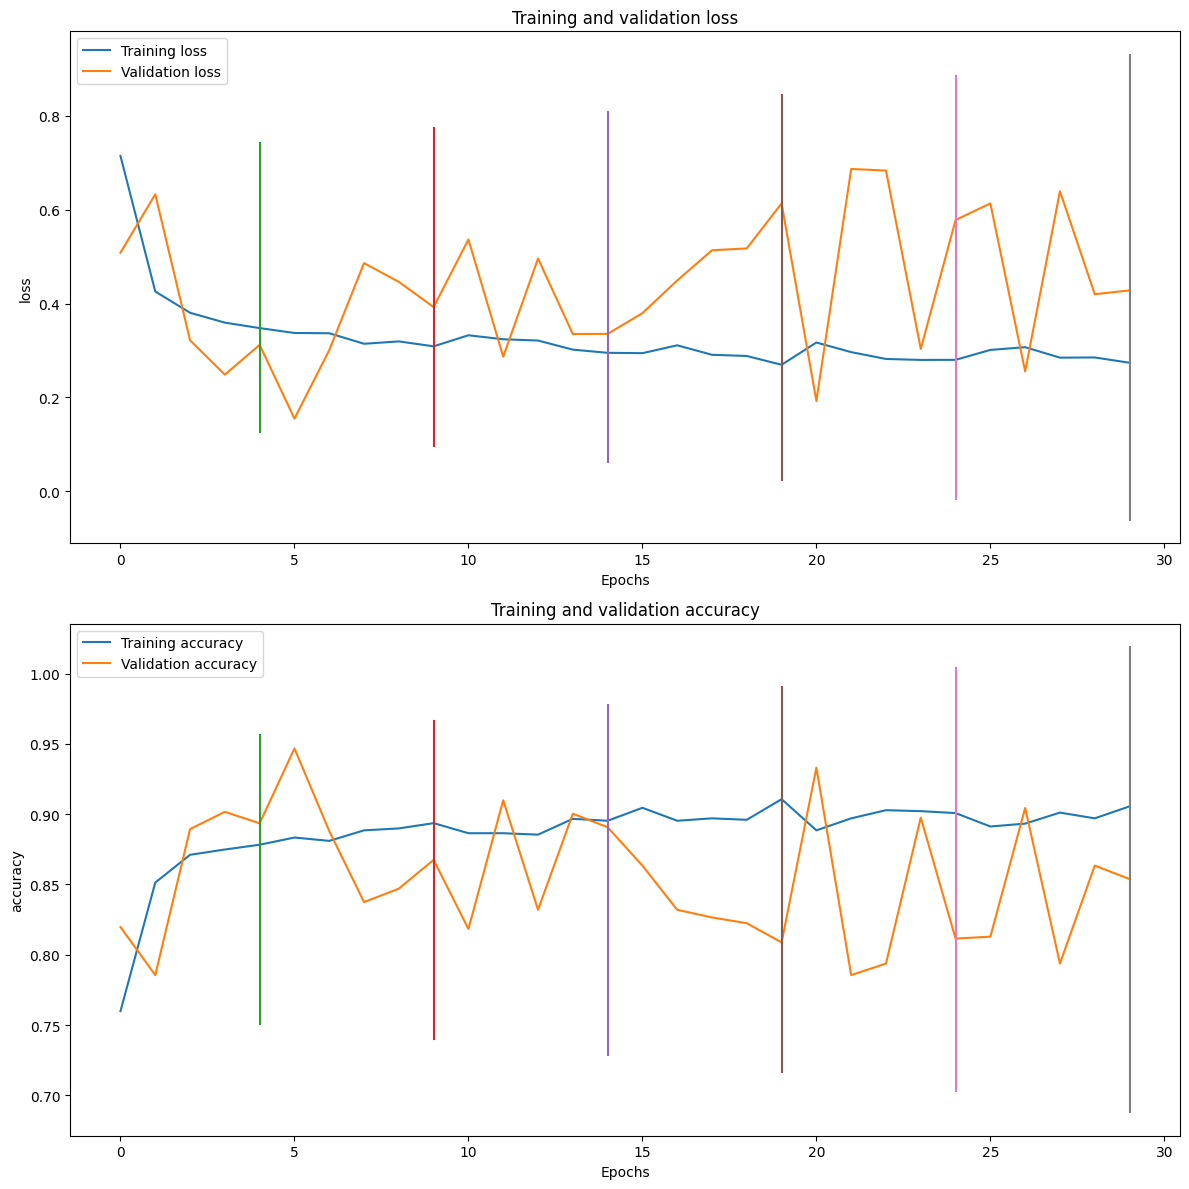

In [ ]:
compare_history_overall(history_lst_mob_aug,
                        initial_epoch_lst = EPOCH_LST)

### Fine-tune the three models, make last 5 layers of each trainable, then fit the normal data

In [21]:
# Making function to make model with n_layers trainable
def make_model_trainable(model, n_train_layers = 5):
  # Unfreeze all of the layers in the model
  model.trainable = True

  # Refreeze every layer except for the last n layers
  for layer in model.layers[:-n_train_layers]:
    layer.trainable = False


#### Resnet model

In [ ]:
# Get the resnet model
resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
resnet_model._name = 'resnet_model_finetune'

# Checkout the layers of the model
for layer_number, layer in enumerate(resnet_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [ ]:
# Make n-layers trainable
make_model_trainable(resnet_model)

# What layers in the model are trainable?
for layer in resnet_model.layers:
  print(layer.name, layer.trainable)

input_3 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(resnet_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
from tensorflow.keras import layers

# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = resnet_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = resnet_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 30]

history_lst_res_fine, eval_lst_res_fine = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_df,
    learning_rate = 1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/resnet_model_finetune_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 3s 56ms/step - loss: 0.6010 - accuracy: 0.8661

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/resnet_model_finetune_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 3s 55ms/step - loss: 0.4612 - accuracy: 0.9180

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/resnet_model_finetune_2.ckpt`
Loading the best weights model 3
Getting t

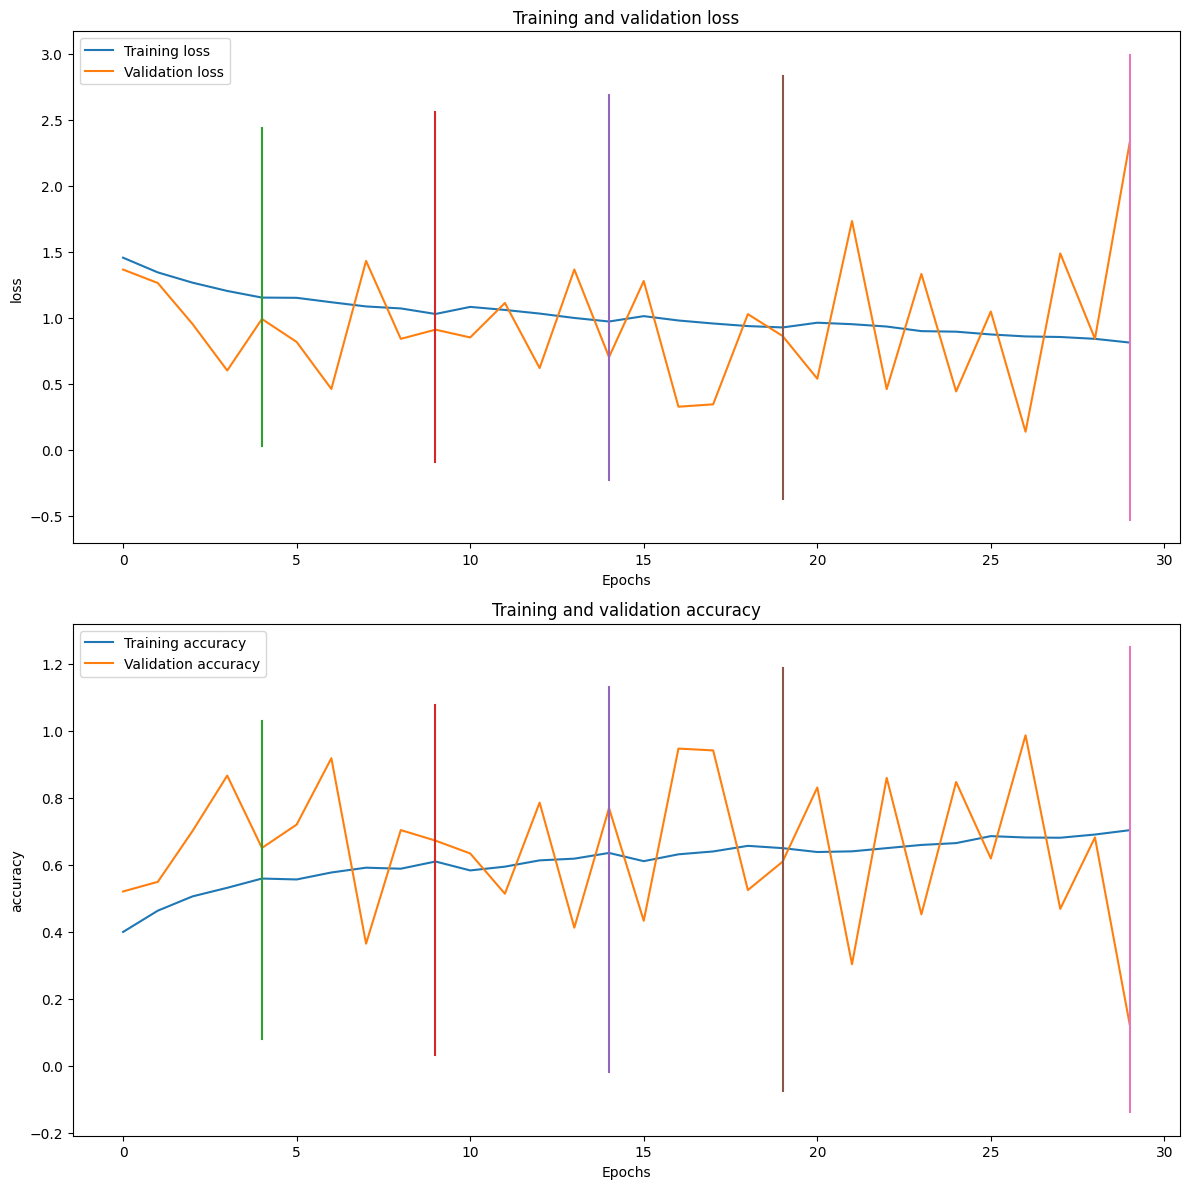

In [ ]:
compare_history_overall(history_lst_res_fine,
                        initial_epoch_lst = EPOCH_LST)

#### EfficientNetB0 model

In [ ]:
# Get the resnet model
efficient_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
efficient_model._name = 'efficient_model_finetune'

# Checkout the layers of the model
for layer_number, layer in enumerate(efficient_model.layers):
  print(layer_number, layer.name, layer.trainable)

16705208/16705208 [==============================] - 0s 0us/step
0 input_4 True
1 rescaling_1 True
2 normalization True
3 rescaling_2 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
3

In [ ]:
# Make n-layers trainable
make_model_trainable(efficient_model)

# What layers in the model are trainable?
for layer in efficient_model.layers:
  print(layer.name, layer.trainable)

input_4 False
rescaling_1 False
normalization False
rescaling_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_pr

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(efficient_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_1 False
2 normalization False
3 rescaling_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False


In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = efficient_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = efficient_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 25, 30]

history_lst_eff_fine, eval_lst_eff_fine = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_df,
    learning_rate=1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/efficient_model_finetune_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 2s 39ms/step - loss: 1.5467 - accuracy: 0.0000e+00

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/efficient_model_finetune_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 3s 61ms/step - loss: 1.5598 - accuracy: 0.0314

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/efficient_model_finetune_2.ckpt`
Loading the best weights mode

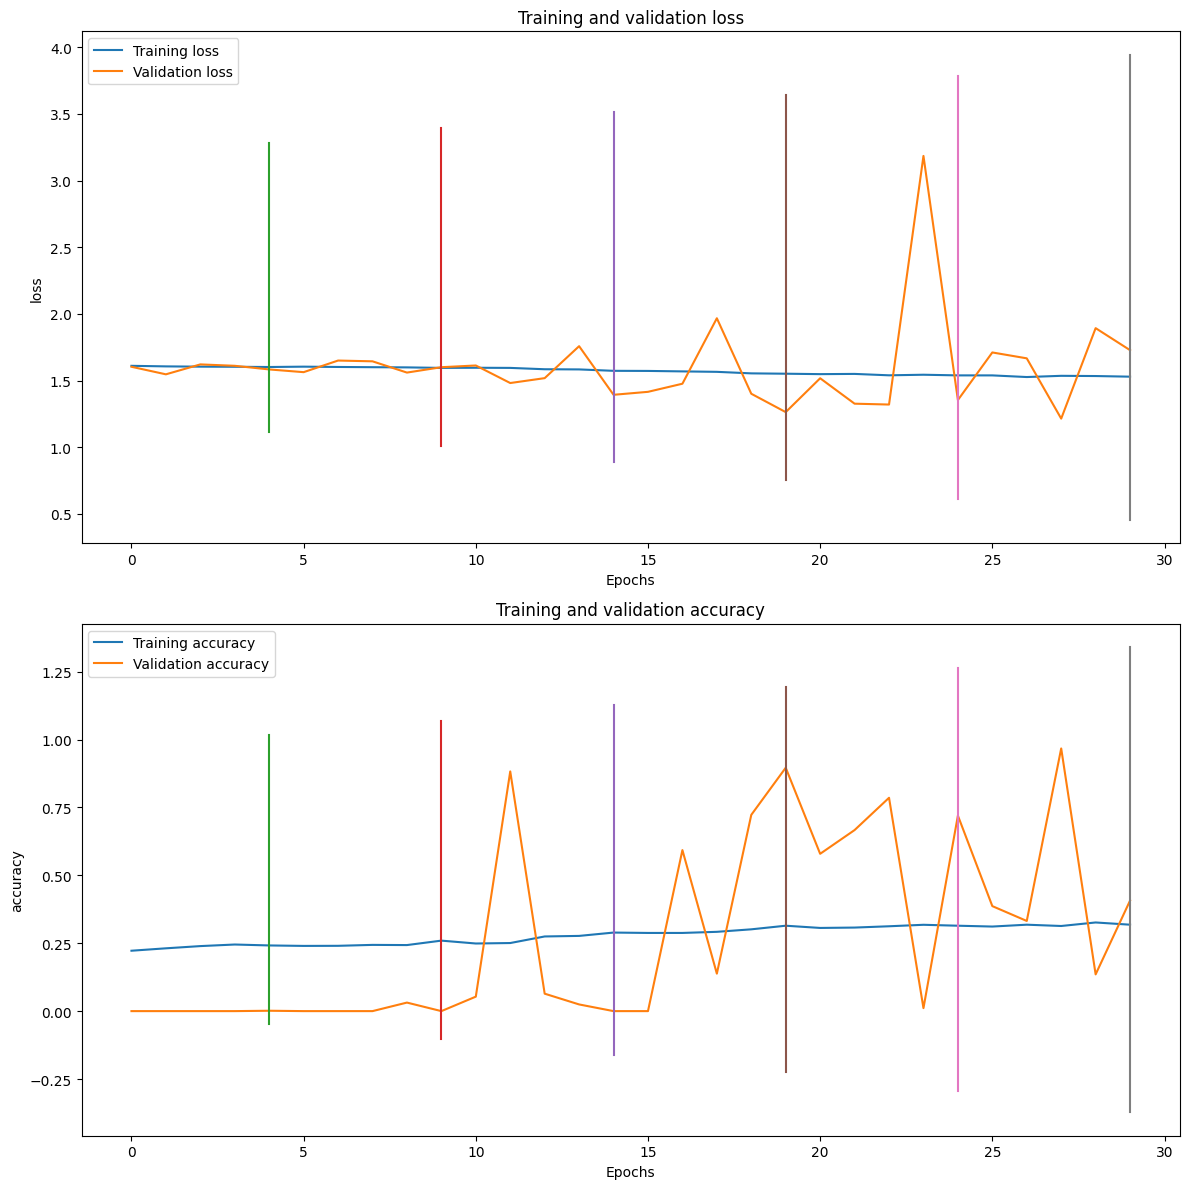

In [ ]:
compare_history_overall(history_lst_eff_fine,
                        initial_epoch_lst = EPOCH_LST)

#### Inception model

In [ ]:
# Get the resnet model
incept_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
incept_model._name = 'inception_model_finetune'

# Checkout the layers of the model
for layer_number, layer in enumerate(incept_model.layers):
  print(layer_number, layer.name, layer.trainable)

87910968/87910968 [==============================] - 1s 0us/step
0 input_5 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch

In [ ]:
# Make n-layers trainable
make_model_trainable(incept_model)

# What layers in the model are trainable?
for layer in incept_model.layers:
  print(layer.name, layer.trainable)

input_5 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activati

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(incept_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = incept_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = incept_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 30, 40, 50]

history_lst_inc_fine, eval_lst_inc_fine = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_df,
    learning_rate=1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/inception_model_finetune_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 2s 44ms/step - loss: 0.3570 - accuracy: 0.9003

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/inception_model_finetune_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 3s 61ms/step - loss: 0.1761 - accuracy: 0.9467

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/inception_model_finetune_2.ckpt`
Loading the best weights model 3


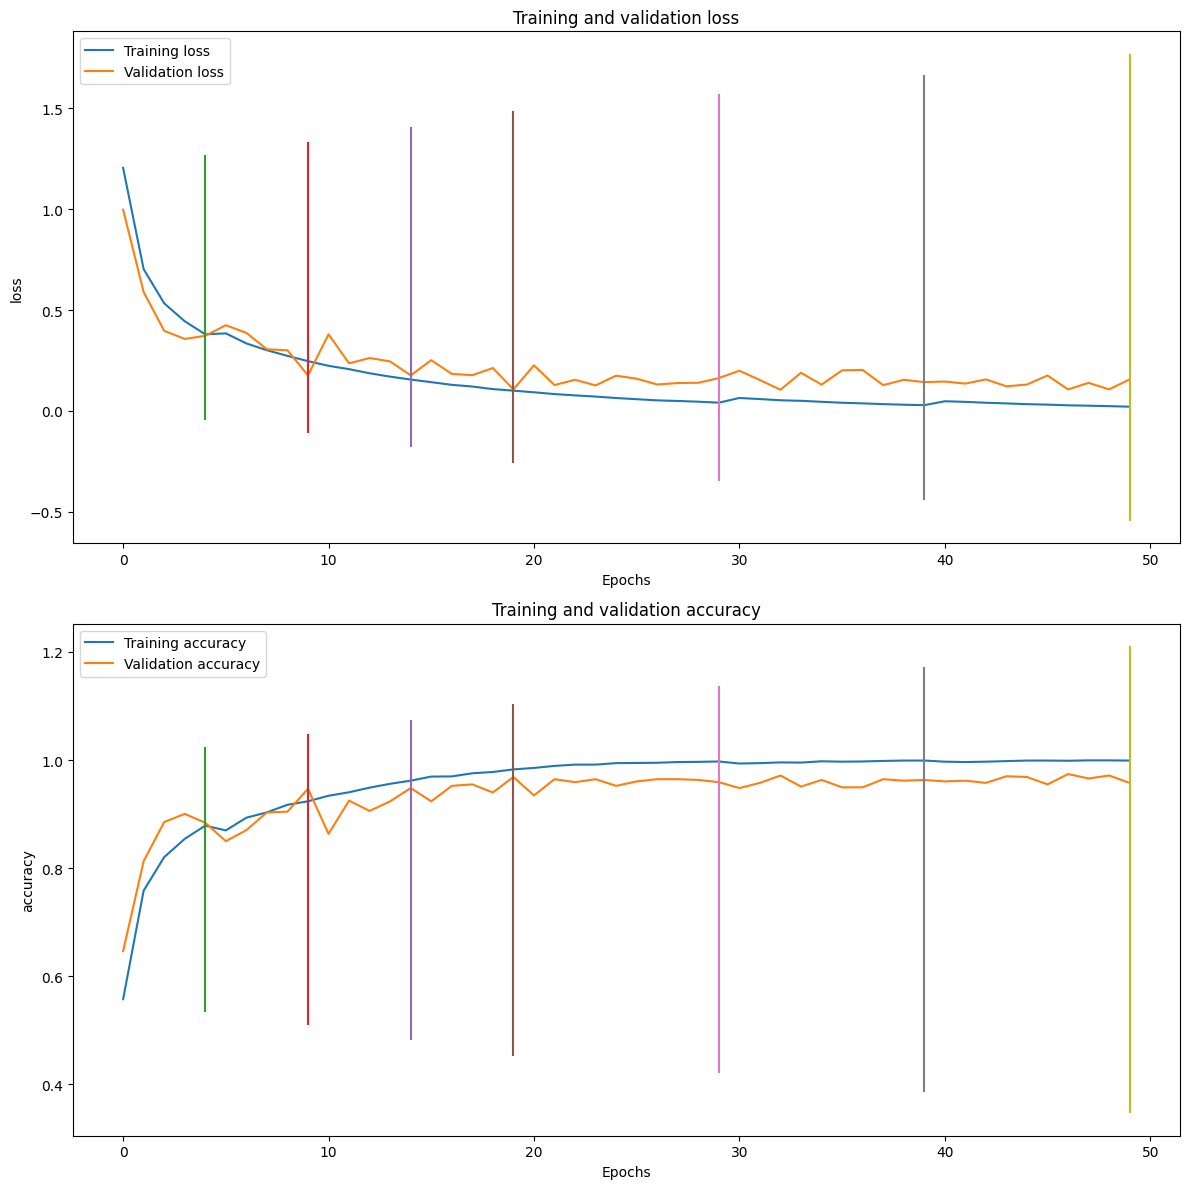

In [ ]:
compare_history_overall(history_lst_inc_fine,
                        initial_epoch_lst = EPOCH_LST)

#### MobileNet model

In [ ]:
# Get the resnet model
mobile_model = tf.keras.applications.mobilenet.MobileNet(include_top=False)
mobile_model._name = 'mobile_model_finetune'

# Checkout the layers of the model
for layer_number, layer in enumerate(mobile_model.layers):
  print(layer_number, layer.name, layer.trainable)

17225924/17225924 [==============================] - 0s 0us/step
0 input_6 True
1 conv1 True
2 conv1_bn True
3 conv1_relu True
4 conv_dw_1 True
5 conv_dw_1_bn True
6 conv_dw_1_relu True
7 conv_pw_1 True
8 conv_pw_1_bn True
9 conv_pw_1_relu True
10 conv_pad_2 True
11 conv_dw_2 True
12 conv_dw_2_bn True
13 conv_dw_2_relu True
14 conv_pw_2 True
15 conv_pw_2_bn True
16 conv_pw_2_relu True
17 conv_dw_3 True
18 conv_dw_3_bn True
19 conv_dw_3_relu True
20 conv_pw_3 True
21 conv_pw_3_bn True
22 conv_pw_3_relu True
23 conv_pad_4 True
24 conv_dw_4 True
25 conv_dw_4_bn True
26 conv_dw_4_relu True
27 conv_pw_4 True
28 conv_pw_4_bn True
29 conv_pw_4_relu True
30 conv_dw_5 True
31 conv_dw_5_bn True
32 conv_dw_5_relu True
33 conv_pw_5 True
34 conv_pw_5_bn True
35 conv_pw_5_relu True
36 conv_pad_6 True
37 conv_dw_6 True
38 conv_dw_6_bn True
39 conv_dw_6_relu True
40 conv_pw_6 True
41 conv_pw_6_bn True
42 conv_pw_6_relu True
43 conv_dw_7 True
44 conv_dw_7_bn True
45 conv_dw_7_relu True
46 conv_pw_7 Tru

In [ ]:
# Make n-layers trainable
make_model_trainable(mobile_model)

# What layers in the model are trainable?
for layer in mobile_model.layers:
  print(layer.name, layer.trainable)

input_6 False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False
conv_pw_8_relu F

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(mobile_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 conv1 False
2 conv1_bn False
3 conv1_relu False
4 conv_dw_1 False
5 conv_dw_1_bn False
6 conv_dw_1_relu False
7 conv_pw_1 False
8 conv_pw_1_bn False
9 conv_pw_1_relu False
10 conv_pad_2 False
11 conv_dw_2 False
12 conv_dw_2_bn False
13 conv_dw_2_relu False
14 conv_pw_2 False
15 conv_pw_2_bn False
16 conv_pw_2_relu False
17 conv_dw_3 False
18 conv_dw_3_bn False
19 conv_dw_3_relu False
20 conv_pw_3 False
21 conv_pw_3_bn False
22 conv_pw_3_relu False
23 conv_pad_4 False
24 conv_dw_4 False
25 conv_dw_4_bn False
26 conv_dw_4_relu False
27 conv_pw_4 False
28 conv_pw_4_bn False
29 conv_pw_4_relu False
30 conv_dw_5 False
31 conv_dw_5_bn False
32 conv_dw_5_relu False
33 conv_pw_5 False
34 conv_pw_5_bn False
35 conv_pw_5_relu False
36 conv_pad_6 False
37 conv_dw_6 False
38 conv_dw_6_bn False
39 conv_dw_6_relu False
40 conv_pw_6 False
41 conv_pw_6_bn False
42 conv_pw_6_relu False
43 conv_dw_7 False
44 conv_dw_7_bn False
45 conv_dw_7_relu False
46 conv_pw_7 False
47 conv_pw_7_bn 

In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = mobile_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = mobile_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 30]

history_lst_mob_fine, eval_lst_mob_fine = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_df,
    learning_rate=1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/mobile_model_finetune_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 1s 30ms/step - loss: 0.1139 - accuracy: 0.9645

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/mobile_model_finetune_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 2s 34ms/step - loss: 0.0875 - accuracy: 0.9740

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/mobile_model_finetune_2.ckpt`
Loading the best weights model 3
Getting t

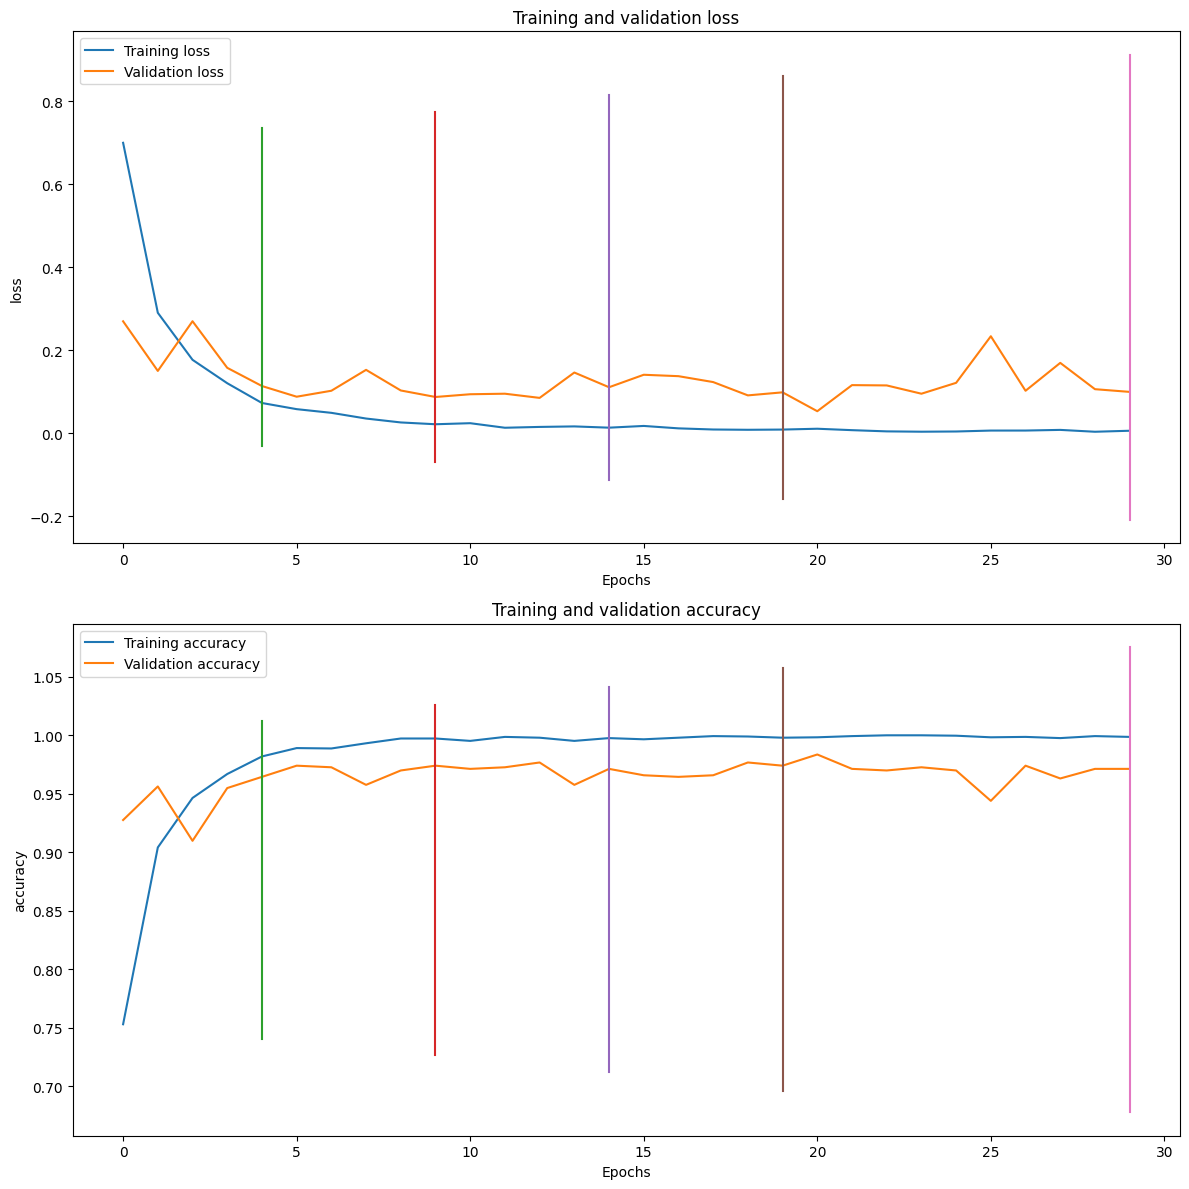

In [ ]:
compare_history_overall(history_lst_mob_fine,
                        initial_epoch_lst = EPOCH_LST)

#### XceptionNet model

In [ ]:
# Get the resnet model
xcept_model = tf.keras.applications.xception.Xception(include_top=False)
xcept_model._name = 'xcept_model_finetune'

# Checkout the layers of the model
for layer_number, layer in enumerate(xcept_model.layers):
  print(layer_number, layer.name, layer.trainable)

83683744/83683744 [==============================] - 1s 0us/step
0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True

In [ ]:
# Make n-layers trainable
make_model_trainable(xcept_model)

# What layers in the model are trainable?
for layer in xcept_model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False
add_3 False
bl

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(xcept_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = xcept_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = xcept_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20]

history_lst_xcp_fine, eval_lst_xcp_fine = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_df,
    learning_rate=1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/xcept_model_finetune_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 3s 72ms/step - loss: 0.1476 - accuracy: 0.9536

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/xcept_model_finetune_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 3s 72ms/step - loss: 0.0891 - accuracy: 0.9686

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/xcept_model_finetune_2.ckpt`
Loading the best weights model 3
Getting the 

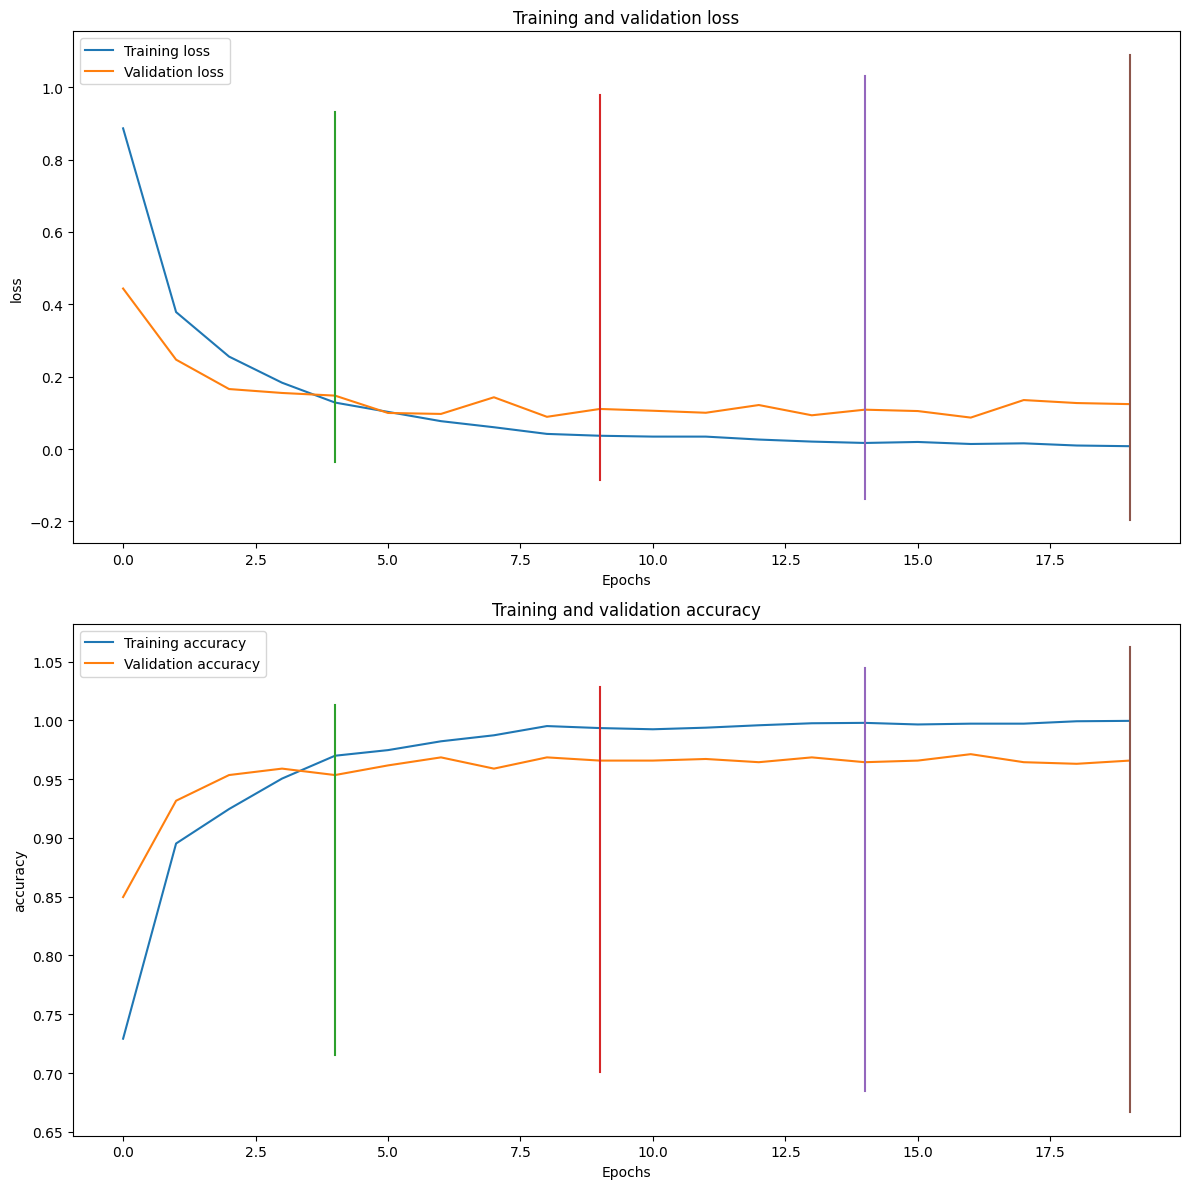

In [ ]:
compare_history_overall(history_lst_xcp_fine,
                        initial_epoch_lst = EPOCH_LST)

### Fine-tuning, do the same as above - but for augmented data

#### Resnet model

In [22]:
# Get the resnet model
resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
resnet_model._name = 'resnet_model_finetune_aug'


In [23]:
# Make n-layers trainable
make_model_trainable(resnet_model)

In [24]:
# Check which layers are trainable
for layer_number, layer in enumerate(resnet_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = resnet_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = resnet_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 30]

history_lst_res_fine_aug, eval_lst_res_fine_aug = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df,
    learning_rate = 1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5

Trained the model till 5 epochs!!!

Model saved at checkpoint path: `model_exp/resnet_model_finetune_aug_0.ckpt`
Loading the best weights model 1
Getting the evaluation results
46/46 [==============================] - 3s 54ms/step - loss: 0.7881 - accuracy: 0.8497

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 5
  Total epochs: 10

Trained the model till 10 epochs!!!

Model saved at checkpoint path: `model_exp/resnet_model_finetune_aug_1.ckpt`
Loading the best weights model 2
Getting the evaluation results
46/46 [==============================] - 3s 55ms/step - loss: 0.6846 - accuracy: 0.8005

--------------------------------------------------

Fitting and training the model: 
  Initial epochs: 10
  Total epochs: 15

Trained the model till 15 epochs!!!

Model saved at checkpoint path: `model_exp/resnet_model_finetune_aug_2.ckpt`
Loading the best weights model

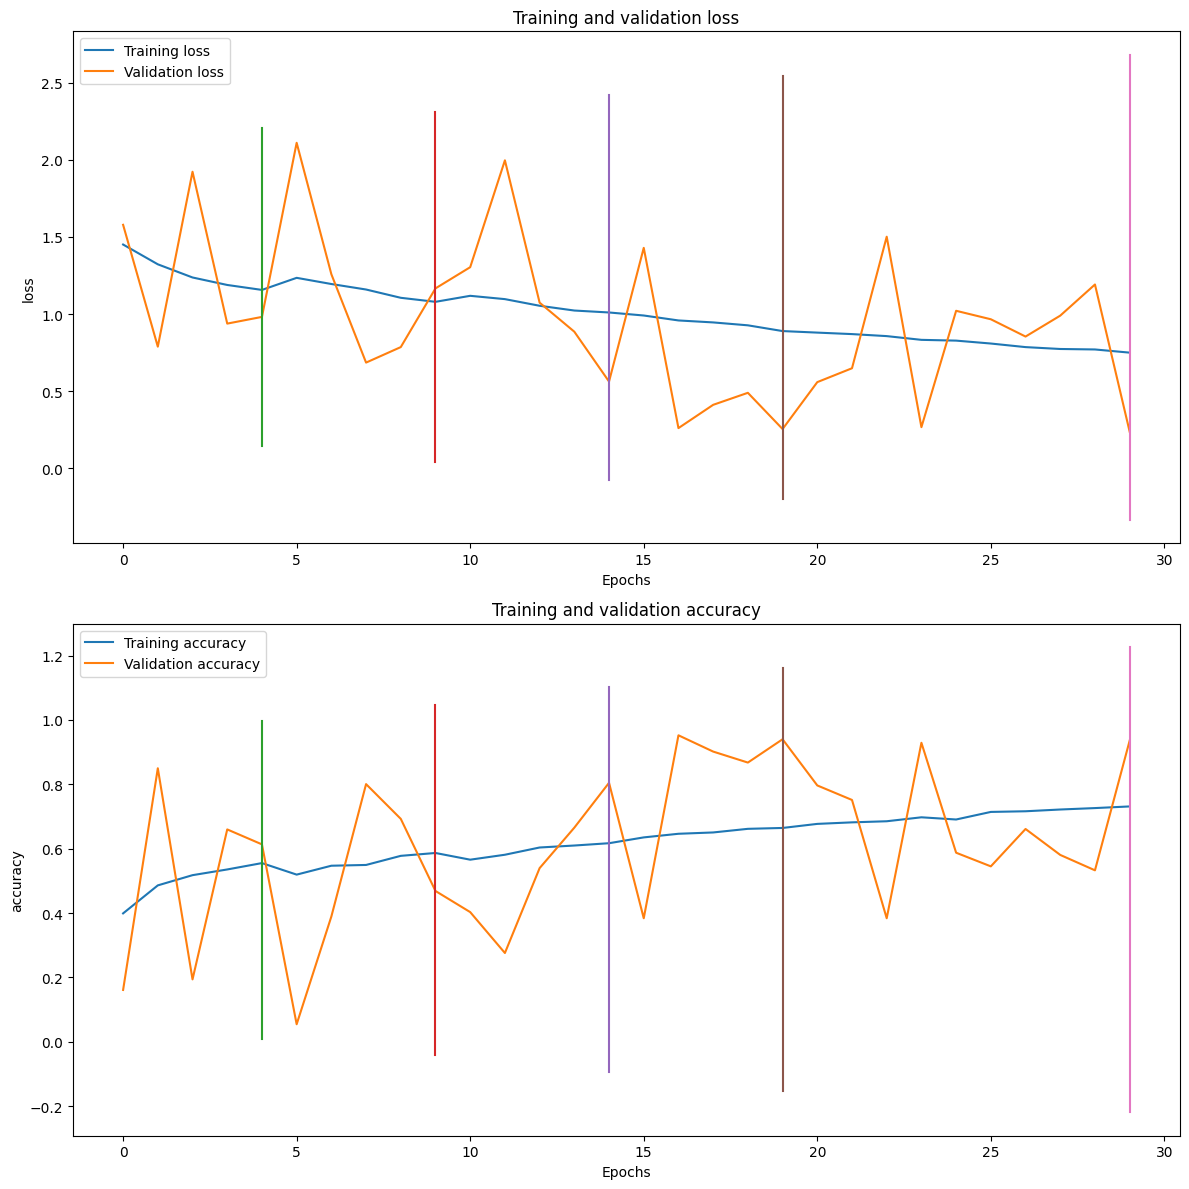

In [26]:
compare_history_overall(history_lst_res_fine_aug,
                        initial_epoch_lst = EPOCH_LST)

#### EfficientNetB0 model

In [27]:
# Get the resnet model
efficient_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
efficient_model._name = 'efficient_model_finetune_aug'

16705208/16705208 [==============================] - 1s 0us/step


In [28]:
# Make n-layers trainable
make_model_trainable(efficient_model)

In [29]:
# Check which layers are trainable
for layer_number, layer in enumerate(efficient_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization False
3 rescaling_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False


In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = efficient_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = efficient_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 25, 30]

history_lst_eff_fine_aug, eval_lst_eff_fine_aug = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df,
    learning_rate=1e-4
)

Fitting and training the model: 
  Initial epochs: 0
  Total epochs: 5



In [ ]:
compare_history_overall(history_lst_eff_fine_aug,
                        initial_epoch_lst = EPOCH_LST)

#### Inception model

In [ ]:
# Get the resnet model
incept_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
incept_model._name = 'inception_model_finetune_aug'

In [ ]:
# Make n-layers trainable
make_model_trainable(incept_model)

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(incept_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = incept_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = incept_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 30, 40, 50]

history_lst_inc_fine_aug, eval_lst_inc_fine_aug = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df,
    learning_rate=1e-4
)

In [ ]:
compare_history_overall(history_lst_inc_fine_aug,
                        initial_epoch_lst = EPOCH_LST)

#### MobileNet model

In [ ]:
# Get the resnet model
mobile_model = tf.keras.applications.mobilenet.MobileNet(include_top=False)
mobile_model._name = 'mobile_model_finetune_aug'

In [ ]:
# Make n-layers trainable
make_model_trainable(mobile_model)

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(mobile_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = mobile_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = mobile_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20, 30]

history_lst_mob_fine_aug, eval_lst_mob_fine_aug = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df,
    learning_rate=1e-4
)

In [ ]:
compare_history_overall(history_lst_mob_fine_aug,
                        initial_epoch_lst = EPOCH_LST)

#### XceptionNet model

In [ ]:
# Get the resnet model
xcept_model = tf.keras.applications.xception.Xception(include_top=False)
xcept_model._name = 'xcept_model_finetune_aug'

In [ ]:
# Make n-layers trainable
make_model_trainable(xcept_model)

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(xcept_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Create model for the resnet
inputs = layers.Input(shape = (224, 224 ,3), name = 'input_layer')
x = xcept_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
model._name = xcept_model._name

# Compile and fit the model for different epochs
EPOCH_LST = [5, 10, 15, 20]

history_lst_xcp_fine_aug, eval_lst_xcp_fine_aug = get_range_epoch_results(
    model,
    epoch_lst=EPOCH_LST,
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    train_data = train_aug_df,
    learning_rate=1e-4
)

In [ ]:
compare_history_overall(history_lst_xcp_fine_aug,
                        initial_epoch_lst = EPOCH_LST)